# Installs

In [ ]:
!pip install transformers --q

In [ ]:
pip install torch --q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install einops --q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install biopython --q

Note: you may need to restart the kernel to use updated packages.


# Imports

In [ ]:
from Bio import SeqIO
import os
import torch
from transformers import AutoTokenizer, AutoModel
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from transformers import TFBertForSequenceClassification
from transformers import OpenAIGPTConfig, OpenAIGPTModel
import torch
import pandas as pd
from tokenizers import Tokenizer
from tokenizers.models import BPE, Unigram, WordLevel, WordPiece
from tokenizers.trainers import BpeTrainer, WordLevelTrainer,WordPieceTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Sequence, Digits, Whitespace
from transformers import PreTrainedTokenizerFast
import random
from tokenizers import Tokenizer, models, trainers
from transformers import BertConfig, BertForSequenceClassification, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, BertForMaskedLM
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertForMaskedLM
from tqdm import tqdm
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel , RobertaTokenizer, TFRobertaModel , AutoTokenizer, AutoModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from transformers import RobertaForMaskedLM, RobertaTokenizer, RobertaTokenizerFast, RobertaConfig
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors
from transformers import RobertaForSequenceClassification
from sklearn.metrics import confusion_matrix
import json

/storage/modules/packages/anaconda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/storage/modules/packages/anaconda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

# Tokenizers

את שני התאים הבאים צריך להריץ בשביל המסקינג

In [ ]:
all_data_pos = pd.read_csv('data_exp1/all_data_combined_df.csv', index_col = False)
all_data_pos['True_label']=1

train_df, validation_df = train_test_split(all_data_pos, test_size=0.2, random_state=42)

In [ ]:
#this will be used for training the tokenizers
df_sequences = all_data_pos['seq'].tolist()
df_labels = all_data_pos['True_label'].tolist()

#this will be used for the pre-train(masking)
df_train_sequences = train_df['seq'].tolist()
df_train_labels = train_df['True_label'].tolist()

df_val_sequences = validation_df['seq'].tolist()
df_val_labels = validation_df['True_label'].tolist()

# wpc - Pretrained

In [ ]:
class DNADataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length=6):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension
        inputs['labels'] = inputs['input_ids'].clone()
        return inputs

In [ ]:
UNK_TOKEN = "[UNK]"  # token for unknown words
SPL_TOKENS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

In [ ]:
def batch_iterator(dataset):
    batch_size = 10000
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]


def train_biological_tokenizer():

    """
    Reads the data from folder, trains the tokenizer, encode the sequences and returns list of data for BERT training
    """
    X_train = df_sequences
    y_train = df_labels
    tokenizer = Tokenizer(WordPiece(unk_token = UNK_TOKEN, max_input_chars_per_word=601))
    trainer = WordPieceTrainer(special_tokens = SPL_TOKENS, continuing_subword_prefix="")
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train_from_iterator(batch_iterator(X_train), trainer) # training the tokenzier
    return tokenizer

In [ ]:
tokenizer = train_biological_tokenizer()

In [ ]:
from collections import defaultdict
vocab = tokenizer.get_vocab()

# Initialize a dictionary to store counts of each token length
token_length_counts = defaultdict(int)

# Iterate through the vocabulary and count the lengths of the tokens
for token in vocab:
    token_length = len(token)
    token_length_counts[token_length] += 1

# Sort the counts by token length
sorted_token_length_counts = dict(sorted(token_length_counts.items()))

# Print the counts of tokens for each length
for length, count in sorted_token_length_counts.items():
    print(f"Token length: {length}, Count: {count}")

Token length: 1, Count: 5
Token length: 2, Count: 14
Token length: 3, Count: 42
Token length: 4, Count: 158
Token length: 5, Count: 390
Token length: 6, Count: 1143
Token length: 7, Count: 4412
Token length: 8, Count: 11231
Token length: 9, Count: 9177
Token length: 10, Count: 2349
Token length: 11, Count: 589
Token length: 12, Count: 258
Token length: 13, Count: 49
Token length: 14, Count: 33
Token length: 15, Count: 21
Token length: 16, Count: 38
Token length: 17, Count: 3
Token length: 18, Count: 13
Token length: 19, Count: 5
Token length: 20, Count: 13
Token length: 21, Count: 3
Token length: 22, Count: 1
Token length: 24, Count: 15
Token length: 25, Count: 1
Token length: 26, Count: 1
Token length: 28, Count: 3
Token length: 32, Count: 13
Token length: 35, Count: 1
Token length: 40, Count: 5
Token length: 44, Count: 2
Token length: 48, Count: 4
Token length: 64, Count: 6
Token length: 96, Count: 1
Token length: 128, Count: 1


In [ ]:
roberta_tokenizer = RobertaTokenizerFast(tokenizer_object=tokenizer, pad_token="[PAD]")

In [ ]:
roberta_tokenizer.save_pretrained("models/wpc_tokenizer_genome")

('models/wpc_tokenizer_genome/tokenizer_config.json',
 'models/wpc_tokenizer_genome/special_tokens_map.json',
 'models/wpc_tokenizer_genome/vocab.txt',
 'models/wpc_tokenizer_genome/added_tokens.json',
 'models/wpc_tokenizer_genome/tokenizer.json')

In [ ]:
# roberta_tokenizer = RobertaTokenizerFast.from_pretrained("models/wpc_tokenizer_genome")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Create a dataset object
train_dataset = DNADataset(df_train_sequences, tokenizer = roberta_tokenizer)
validation_dataset = DNADataset(df_val_sequences, tokenizer = roberta_tokenizer)

# Create a dataloader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define special tokens (if not already defined in the tokenizer)
special_tokens = {
    'pad_token': '<pad>',
    'bos_token': '<s>',
    'eos_token': '</s>',
    'unk_token': '<unk>',
    'cls_token': '<cls>',
    'sep_token': '<sep>',
    'mask_token': '<mask>'
}

# Add special tokens to the tokenizer
roberta_tokenizer.add_special_tokens({'additional_special_tokens': list(special_tokens.values())})

# Resize the tokenizer vocabulary to include the new special tokens
roberta_tokenizer.add_tokens([token for token in special_tokens.values()])

# Retrieve the special token IDs
pad_token_id = roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.pad_token)
bos_token_id = roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.bos_token)
eos_token_id = roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.eos_token)

# Print the token IDs to verify
print("Pad token ID:", pad_token_id)
print("BOS token ID:", bos_token_id)
print("EOS token ID:", eos_token_id)

# Ensure the token IDs are within the updated vocabulary size
updated_vocab_size = len(roberta_tokenizer)
assert pad_token_id < updated_vocab_size, "Padding_idx must be within num_embeddings"
assert bos_token_id < updated_vocab_size, "BOS token ID must be within num_embeddings"
assert eos_token_id < updated_vocab_size, "EOS token ID must be within num_embeddings"

Pad token ID: 0
BOS token ID: 30000
EOS token ID: 30001


In [ ]:
# # Initialize the model - pretrined model
# model = RobertaForMaskedLM.from_pretrained("roberta-base").to(device)

# Define model configuration
config = RobertaConfig(
    vocab_size=updated_vocab_size,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    pad_token_id=pad_token_id,
    bos_token_id=bos_token_id,
    eos_token_id=eos_token_id
)

# Initialize the model
model = RobertaForMaskedLM(config)

In [ ]:
# Define training parameters
num_epochs = 2
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_history=[]
val_history=[]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_dataloader):
        inputs = {key: val.to(model.device) for key, val in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i>0 and i % 300 ==0:
            print(f"Epoch {epoch+1}/{num_epochs}, Iteration {i}, Training Loss: {total_loss/i:.4f}")

    avg_loss = total_loss / len(train_dataloader)
    train_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for val_batch in validation_dataloader:
            val_inputs = {key: val.to(model.device) for key, val in val_batch.items()}
            val_outputs = model(**val_inputs)
            val_loss = val_outputs.loss
            val_losses.append(val_loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)
        val_history.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

/storage/modules/packages/anaconda/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Iteration 300, Training Loss: 9.3044
Epoch 1/2, Iteration 600, Training Loss: 8.3378
Epoch 1/2, Iteration 900, Training Loss: 7.5454
Epoch 1/2, Iteration 1200, Training Loss: 6.8752
Epoch 1/2, Iteration 1500, Training Loss: 6.2997
Epoch 1/2, Iteration 1800, Training Loss: 5.8136
Epoch 1/2, Iteration 2100, Training Loss: 5.3911
Epoch 1/2, Iteration 2400, Training Loss: 5.0249
Epoch 1/2, Iteration 2700, Training Loss: 4.7038
Epoch 1/2, Iteration 3000, Training Loss: 4.4203
Epoch 1/2, Iteration 3300, Training Loss: 4.1672
Epoch 1/2, Iteration 3600, Training Loss: 3.9397
Epoch 1/2, Iteration 3900, Training Loss: 3.7351
Epoch 1/2, Iteration 4200, Training Loss: 3.5491
Epoch 1/2, Iteration 4500, Training Loss: 3.3802
Epoch 1/2, Iteration 4800, Training Loss: 3.2260
Epoch 1/2, Iteration 5100, Training Loss: 3.0843
Epoch 1/2, Iteration 5400, Training Loss: 2.9536
Epoch 1/2, Iteration 5700, Training Loss: 2.8324
Epoch 1/2, Iteration 6000, Training Loss: 2.7204
Epoch 1/2, Iteration 63

In [ ]:
# Save the model
model.save_pretrained("models/wpc_masking_model_genome")

In [ ]:
train_history

[1.5352030692573977, 0.03872717509199327]

In [ ]:
val_history

[0.033648819738669934, 0.005310874395204251]

# wpc FineTune

In [ ]:
train = pd.read_csv("data_e2m2/train_exp2.csv", index_col = False)
val = pd.read_csv("data_e2m2/val_exp2.csv", index_col = False)
test_tata = pd.read_csv('data_e2m2/test_tata_exp2.csv', index_col = False)
test_non_tata = pd.read_csv('data_e2m2/test_non_tata_exp2.csv', index_col = False)

In [ ]:
# Rename columns in the DataFrames
train.rename(columns={'name': 'organism', 'True_label': 'True_Label'}, inplace=True)
val.rename(columns={'name': 'organism', 'True_label': 'True_Label'}, inplace=True)
test_tata.rename(columns={'name': 'organism', 'True_label': 'True_Label'}, inplace=True)
test_non_tata.rename(columns={'name': 'organism', 'True_label': 'True_Label'}, inplace=True)

In [ ]:
class DNAClassificationDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=128):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}  # Remove batch dimension

        # Ensure the label is an integer
        inputs['labels'] = torch.tensor(int(label), dtype=torch.long)
        return inputs



In [ ]:
import torch
from transformers import AdamW, RobertaForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef


class ClassificationModelWPC:

    def __init__(self, train_df, val_df, test_tata_df, test_non_tata_df, organism='human', b_size=8):
        self.organism = organism
        self.batch_size = b_size
        self.dataframes = {
            'train': train_df,
            'val': val_df,
            'test_tata': test_tata_df,
            'test_non_tata': test_non_tata_df
        }

        self.tokenizer = RobertaTokenizerFast.from_pretrained("models/wpc_tokenizer_genome")
        self.masking_model = RobertaForMaskedLM.from_pretrained("models/wpc_masking_model_genome")
        self.create_model()

        # Create dataloaders and set as attributes
        dataloaders = self.create_dataloaders(batch_size=self.batch_size)
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.test_tata_dataloader = dataloaders['test_tata']
        self.test_non_tata_dataloader = dataloaders['test_non_tata']

    def filter_and_convert(self, df, organism):
        filtered_df = df[df['organism'] == organism]
        seq_list = filtered_df['seq'].tolist()
        label_list = filtered_df['True_Label'].tolist()
        return seq_list, label_list

    def create_dataloaders(self, batch_size=16):
        train_seq, train_labels = self.filter_and_convert(self.dataframes['train'], self.organism)
        val_seq, val_labels = self.filter_and_convert(self.dataframes['val'], self.organism)
        test_tata_seq, test_tata_labels = self.filter_and_convert(self.dataframes['test_tata'], self.organism)
        test_non_tata_seq, test_non_tata_labels = self.filter_and_convert(self.dataframes['test_non_tata'], self.organism)

        # Create the dataset and dataloader
        train_dataset = DNAClassificationDataset(train_seq, train_labels, self.tokenizer)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = DNAClassificationDataset(val_seq, val_labels, self.tokenizer)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        test_tata_dataset = DNAClassificationDataset(test_tata_seq, test_tata_labels, self.tokenizer)
        test_tata_dataloader = DataLoader(test_tata_dataset, batch_size=batch_size, shuffle=True)

        test_non_tata_dataset = DNAClassificationDataset(test_non_tata_seq, test_non_tata_labels, self.tokenizer)
        test_non_tata_dataloader = DataLoader(test_non_tata_dataset, batch_size=batch_size, shuffle=True)

        return {
            'train': train_dataloader,
            'val': val_dataloader,
            'test_tata': test_tata_dataloader,
            'test_non_tata': test_non_tata_dataloader
        }

    def create_model(self):
        # Define configuration for sequence classification
        config = RobertaConfig.from_pretrained("models/wpc_masking_model_genome")
        config.num_labels = 2  # binary classification

        # Initialize the sequence classification model
        self.classification_model = RobertaForSequenceClassification(config)

        # Copy the pre-trained weights from the masked language model
        self.classification_model.roberta.load_state_dict(self.masking_model.roberta.state_dict())
        # return classification_model

    def train_model(self, num_epochs=60, base_lr=1e-5, patience=3):

        train_dataloader = self.train_dataloader
        val_dataloader = self.val_dataloader

        optimizer = torch.optim.AdamW(self.classification_model.parameters(), lr=base_lr)
        scheduler = MultiStepLR(optimizer, milestones=list(range(4,num_epochs+1,4)), gamma=0.85)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classification_model.to(device)

       # Initialize history dictionaries
        train_history = {
            'loss': [],
            'accuracy': []
        }
        val_history = {
            'loss': [],
            'accuracy': [],
            'f1': [],
            'auc': [],
            'mcc': []
        }

        # Initialize early stopping criteria
        best_val_accuracy = 0.0
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            # Training phase
            self.classification_model.train()
            total_train_loss = 0
            correct_train_predictions = 0
            total_train_predictions = 0

            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                optimizer.step()
                scheduler.step()

                # Calculate training accuracy
                total_train_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_train_predictions += torch.sum(preds == labels).item()
                total_train_predictions += labels.size(0)

            avg_train_loss = total_train_loss / len(train_dataloader)
            train_accuracy = correct_train_predictions / total_train_predictions
            train_history['loss'].append(avg_train_loss)
            train_history['accuracy'].append(train_accuracy)

            # Validation phase
            self.classification_model.eval()
            total_val_loss = 0
            correct_val_predictions = 0
            total_val_predictions = 0

            all_labels = []
            all_preds = []
            all_probs = []

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits

                    # Calculate validation accuracy
                    total_val_loss += loss.item()
                    preds = torch.argmax(logits, dim=1)
                    probs = torch.softmax(logits, dim=1)[:, 1]

                    correct_val_predictions += torch.sum(preds == labels).item()
                    total_val_predictions += labels.size(0)

                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_accuracy = correct_val_predictions / total_val_predictions
            val_f1 = f1_score(all_labels, all_preds)
            val_auc = roc_auc_score(all_labels, all_probs)
            val_mcc = matthews_corrcoef(all_labels, all_preds)

            val_history['loss'].append(avg_val_loss)
            val_history['accuracy'].append(val_accuracy)
            val_history['f1'].append(val_f1)
            val_history['auc'].append(val_auc)
            val_history['mcc'].append(val_mcc)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Check early stopping criteria
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered")
                    break

        # Save the trained classification model
        self.classification_model.save_pretrained(f"models/wpc fine tune models/method1/wpc_cls_{self.organism}_model_b{self.batch_size}")
        with open(f"models/wpc fine tune models/method1/wpc_cls_{self.organism}_model_b{self.batch_size}_history.pkl", 'wb') as f:
            pickle.dump((train_history, val_history), f)

        return train_history, val_history

    def test_model(self, wrong_idx_dict, tata_flag):
        if tata_flag == 'tata':
            test_dataloader = self.test_tata_dataloader
        elif tata_flag == 'non_tata':
            test_dataloader = self.test_non_tata_dataloader
        elif tata_flag == 'combined':
            test_dataloader = torch.utils.data.DataLoader(
                torch.utils.data.ConcatDataset([self.test_tata_dataloader.dataset, self.test_non_tata_dataloader.dataset]),
                batch_size=self.batch_size,
                shuffle=True
            )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classification_model.to(device)
        self.classification_model.eval()

        total_test_loss = 0
        correct_test_predictions = 0
        total_test_predictions = 0

        all_labels = []
        all_preds = []
        all_probs = []
        all_indices = []
        incorrect_indices = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self.classification_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_test_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                probs = torch.softmax(logits, dim=1)[:, 1]

                correct_test_predictions += torch.sum(preds == labels).item()
                total_test_predictions += labels.size(0)

                batch_indices = list(range(batch_idx * self.batch_size, batch_idx * self.batch_size + labels.size(0)))
                all_indices.extend(batch_indices)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

                incorrect_batch_indices = [i for i, (pred, label) in zip(batch_indices, zip(preds.cpu().numpy(), labels.cpu().numpy())) if pred != label]
                incorrect_indices.extend(incorrect_batch_indices)

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_accuracy = correct_test_predictions / total_test_predictions
        test_f1 = f1_score(all_labels, all_preds)
        test_auc = roc_auc_score(all_labels, all_probs)
        test_mcc = matthews_corrcoef(all_labels, all_preds)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        print(tata_flag)
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
        print(f"Test MCC: {test_mcc:.4f}")
        print(f"True Positive Rate: {tp_rate:.4f}")
        print(f"False Positive Rate: {fp_rate:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Negatives (FN): {fn}")
        wrong_idx_dict[f'{self.organism}_{tata_flag}'] = incorrect_indices
        wrong_idx_dict = {str(key): value for key, value in wrong_idx_dict.items()}

        print()

        test_metrics = {
            'loss': avg_test_loss,
            'accuracy': test_accuracy,
            'f1': test_f1,
            'auc': test_auc,
            'mcc': test_mcc,
            'tp_rate': tp_rate,
            'fp_rate': fp_rate,
            'precision': precision,
            'recall': recall,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn,
        }
        return test_metrics, wrong_idx_dict


    def fine_tune_model(self, num_epochs=15, base_lr=1e-5):
        wrong_idx_dict = defaultdict(list)
        model_path = f"models/wpc fine tune models/method1/wpc_cls_{self.organism}_model_b{self.batch_size}"
        history_path = f"models/wpc fine tune models/method1/wpc_cls_{self.organism}_model_b{self.batch_size}_history.pkl"

        if os.path.exists(model_path):
            self.classification_model = RobertaForSequenceClassification.from_pretrained(model_path)
            with open(history_path, 'rb') as f:
                train_history, val_history = pickle.load(f)
        else:
            train_history, val_history = self.train_model(num_epochs=num_epochs, base_lr=base_lr)


        test_tata_history,wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='tata')

        test_non_tata_history, wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='non_tata')

        # Combine both test sets
        test_combined_history, wrong_idx_dict = self.test_model(wrong_idx_dict, tata_flag='combined')

        # Save the dictionary as a JSON file
        with open(f'wrong_idx/wpc/genome/wpc_gen_{self.organism}.json', 'w') as json_file:
            json.dump(wrong_idx_dict, json_file, indent=4)

        return train_history, val_history, test_tata_history, test_non_tata_history, test_combined_history

### EXP-WPC

In [ ]:
b_size=16
num_epochs=40
base_lr=1e-4
results_dict = defaultdict(dict)

**celegans**

In [ ]:
organism = 'celegans'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7086, Train Accuracy: 0.5022, Val Loss: 0.7066, Val Accuracy: 0.5002
Epoch 2/40, Train Loss: 0.6900, Train Accuracy: 0.5451, Val Loss: 0.6956, Val Accuracy: 0.5516
Epoch 3/40, Train Loss: 0.4480, Train Accuracy: 0.7875, Val Loss: 0.5800, Val Accuracy: 0.7284
Epoch 4/40, Train Loss: 0.1614, Train Accuracy: 0.9410, Val Loss: 0.8072, Val Accuracy: 0.7236
Epoch 5/40, Train Loss: 0.0610, Train Accuracy: 0.9788, Val Loss: 1.0985, Val Accuracy: 0.7288
Epoch 6/40, Train Loss: 0.0328, Train Accuracy: 0.9900, Val Loss: 1.2718, Val Accuracy: 0.7301
Epoch 7/40, Train Loss: 0.0182, Train Accuracy: 0.9943, Val Loss: 1.7534, Val Accuracy: 0.6959
Epoch 8/40, Train Loss: 0.0160, Train Accuracy: 0.9952, Val Loss: 1.4252, Val Accuracy: 0.7266
Epoch 9/40, Train Loss: 0.0125, Train Accuracy: 0.9965, Val Loss: 1.7161, Val Accuracy: 0.7161
Early stopping triggered
tata
Test Loss: 2.1010
Test Accuracy: 0.6617
Test F1 Score: 0.7028
Test AUC: 0.7067
Test MCC: 0.3356
True Positive Rate:

**gallus**

In [ ]:
organism = 'gallus'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.4188, Train Accuracy: 0.7915, Val Loss: 0.2916, Val Accuracy: 0.9054
Epoch 2/40, Train Loss: 0.2172, Train Accuracy: 0.9242, Val Loss: 0.2721, Val Accuracy: 0.8992
Epoch 3/40, Train Loss: 0.1279, Train Accuracy: 0.9579, Val Loss: 0.3525, Val Accuracy: 0.8812
Epoch 4/40, Train Loss: 0.0555, Train Accuracy: 0.9821, Val Loss: 0.3586, Val Accuracy: 0.9121
Epoch 5/40, Train Loss: 0.0201, Train Accuracy: 0.9956, Val Loss: 0.4902, Val Accuracy: 0.9023
Epoch 6/40, Train Loss: 0.0071, Train Accuracy: 0.9990, Val Loss: 0.6160, Val Accuracy: 0.8864
Epoch 7/40, Train Loss: 0.0089, Train Accuracy: 0.9972, Val Loss: 0.6020, Val Accuracy: 0.8982
Early stopping triggered
tata
Test Loss: 0.8821
Test Accuracy: 0.8582
Test F1 Score: 0.8455
Test AUC: 0.9100
Test MCC: 0.7285
True Positive Rate: 0.7704
False Positive Rate: 0.0526
Precision: 0.9369
Recall: 0.7704
True Positives (TP): 104
False Positives (FP): 7
True Negatives (TN): 126
False Negatives (FN): 31

non_tata
Test Loss: 0

**human**

In [ ]:
organism = 'human'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.3584, Train Accuracy: 0.8356, Val Loss: 0.4680, Val Accuracy: 0.8094
Epoch 2/40, Train Loss: 0.2129, Train Accuracy: 0.9179, Val Loss: 0.4856, Val Accuracy: 0.8258
Epoch 3/40, Train Loss: 0.1210, Train Accuracy: 0.9573, Val Loss: 0.4826, Val Accuracy: 0.8229
Epoch 4/40, Train Loss: 0.0630, Train Accuracy: 0.9806, Val Loss: 0.7172, Val Accuracy: 0.8214
Epoch 5/40, Train Loss: 0.0395, Train Accuracy: 0.9886, Val Loss: 0.6686, Val Accuracy: 0.8148
Early stopping triggered
tata
Test Loss: 0.8370
Test Accuracy: 0.7756
Test F1 Score: 0.7640
Test AUC: 0.8376
Test MCC: 0.5577
True Positive Rate: 0.7117
False Positive Rate: 0.1579
Precision: 0.8245
Recall: 0.7117
True Positives (TP): 437
False Positives (FP): 93
True Negatives (TN): 496
False Negatives (FN): 177

non_tata
Test Loss: 0.6512
Test Accuracy: 0.8227
Test F1 Score: 0.8203
Test AUC: 0.8909
Test MCC: 0.6473
True Positive Rate: 0.7933
False Positive Rate: 0.1466
Precision: 0.8493
Recall: 0.7933
True Positives (

**melanogaster**

In [ ]:
organism = 'melanogaster'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7044, Train Accuracy: 0.4989, Val Loss: 0.6947, Val Accuracy: 0.5005
Epoch 2/40, Train Loss: 0.6898, Train Accuracy: 0.5469, Val Loss: 0.6832, Val Accuracy: 0.5602
Epoch 3/40, Train Loss: 0.5101, Train Accuracy: 0.7511, Val Loss: 0.6957, Val Accuracy: 0.6681
Epoch 4/40, Train Loss: 0.2842, Train Accuracy: 0.8841, Val Loss: 0.7956, Val Accuracy: 0.6561
Epoch 5/40, Train Loss: 0.1538, Train Accuracy: 0.9428, Val Loss: 1.1247, Val Accuracy: 0.6598
Epoch 6/40, Train Loss: 0.0812, Train Accuracy: 0.9717, Val Loss: 1.5185, Val Accuracy: 0.6543
Early stopping triggered
tata
Test Loss: 1.6449
Test Accuracy: 0.6214
Test F1 Score: 0.5841
Test AUC: 0.6855
Test MCC: 0.2472
True Positive Rate: 0.5308
False Positive Rate: 0.2876
Precision: 0.6494
Recall: 0.5308
True Positives (TP): 276
False Positives (FP): 149
True Negatives (TN): 369
False Negatives (FN): 244

non_tata
Test Loss: 1.4423
Test Accuracy: 0.6706
Test F1 Score: 0.6566
Test AUC: 0.7288
Test MCC: 0.3424
True Pos

**mulatta**

In [ ]:
organism = 'mulatta'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.3617, Train Accuracy: 0.8167, Val Loss: 0.2369, Val Accuracy: 0.9163
Epoch 2/40, Train Loss: 0.1354, Train Accuracy: 0.9585, Val Loss: 0.2447, Val Accuracy: 0.9197
Epoch 3/40, Train Loss: 0.0626, Train Accuracy: 0.9816, Val Loss: 0.2699, Val Accuracy: 0.9197
Epoch 4/40, Train Loss: 0.0271, Train Accuracy: 0.9923, Val Loss: 0.3757, Val Accuracy: 0.9208
Epoch 5/40, Train Loss: 0.0090, Train Accuracy: 0.9978, Val Loss: 0.3913, Val Accuracy: 0.9174
Epoch 6/40, Train Loss: 0.0034, Train Accuracy: 0.9992, Val Loss: 0.4562, Val Accuracy: 0.9235
Epoch 7/40, Train Loss: 0.0175, Train Accuracy: 0.9947, Val Loss: 0.4826, Val Accuracy: 0.9246
Epoch 8/40, Train Loss: 0.0102, Train Accuracy: 0.9965, Val Loss: 0.5126, Val Accuracy: 0.9212
Epoch 9/40, Train Loss: 0.0008, Train Accuracy: 0.9996, Val Loss: 0.5525, Val Accuracy: 0.9223
Epoch 10/40, Train Loss: 0.0001, Train Accuracy: 1.0000, Val Loss: 0.6061, Val Accuracy: 0.9258
Epoch 11/40, Train Loss: 0.0000, Train Accuracy: 

**musculus**

In [ ]:
organism = 'musculus'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.3952, Train Accuracy: 0.8017, Val Loss: 0.3540, Val Accuracy: 0.8468
Epoch 2/40, Train Loss: 0.2329, Train Accuracy: 0.9052, Val Loss: 0.2710, Val Accuracy: 0.8871
Epoch 3/40, Train Loss: 0.1414, Train Accuracy: 0.9474, Val Loss: 0.2718, Val Accuracy: 0.9050
Epoch 4/40, Train Loss: 0.0748, Train Accuracy: 0.9757, Val Loss: 0.3809, Val Accuracy: 0.8970
Epoch 5/40, Train Loss: 0.0482, Train Accuracy: 0.9852, Val Loss: 0.3832, Val Accuracy: 0.9139
Epoch 6/40, Train Loss: 0.0302, Train Accuracy: 0.9910, Val Loss: 0.5017, Val Accuracy: 0.8887
Epoch 7/40, Train Loss: 0.0251, Train Accuracy: 0.9924, Val Loss: 0.6405, Val Accuracy: 0.8823
Epoch 8/40, Train Loss: 0.0192, Train Accuracy: 0.9948, Val Loss: 0.3856, Val Accuracy: 0.9152
Epoch 9/40, Train Loss: 0.0146, Train Accuracy: 0.9962, Val Loss: 0.5857, Val Accuracy: 0.8813
Epoch 10/40, Train Loss: 0.0134, Train Accuracy: 0.9961, Val Loss: 0.6045, Val Accuracy: 0.8979
Epoch 11/40, Train Loss: 0.0093, Train Accuracy: 

**norvegicus**

In [ ]:
organism = 'norvegicus'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.4564, Train Accuracy: 0.7431, Val Loss: 0.3568, Val Accuracy: 0.8507
Epoch 2/40, Train Loss: 0.1924, Train Accuracy: 0.9267, Val Loss: 0.3645, Val Accuracy: 0.8578
Epoch 3/40, Train Loss: 0.0861, Train Accuracy: 0.9727, Val Loss: 0.4113, Val Accuracy: 0.8720
Epoch 4/40, Train Loss: 0.0379, Train Accuracy: 0.9893, Val Loss: 0.6507, Val Accuracy: 0.8659
Epoch 5/40, Train Loss: 0.0219, Train Accuracy: 0.9938, Val Loss: 0.5711, Val Accuracy: 0.8661
Epoch 6/40, Train Loss: 0.0128, Train Accuracy: 0.9972, Val Loss: 0.6994, Val Accuracy: 0.8666
Early stopping triggered
tata
Test Loss: 1.2057
Test Accuracy: 0.7920
Test F1 Score: 0.7639
Test AUC: 0.8551
Test MCC: 0.6003
True Positive Rate: 0.6748
False Positive Rate: 0.0915
Precision: 0.8800
Recall: 0.6748
True Positives (TP): 110
False Positives (FP): 15
True Negatives (TN): 149
False Negatives (FN): 53

non_tata
Test Loss: 0.7247
Test Accuracy: 0.8571
Test F1 Score: 0.8537
Test AUC: 0.9214
Test MCC: 0.7146
True Posit

**rerio**

In [ ]:
organism = 'rerio'

cls_model = ClassificationModelWPC(train, val, test_tata, test_non_tata, organism=organism,b_size=b_size)
train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history = cls_model.fine_tune_model(num_epochs=num_epochs, base_lr=base_lr)
results_dict[f'{organism}_b{b_size}'] = [train_history, val_history, test_tata_history, test_non_tata_history, test_all_data_history]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/40, Train Loss: 0.7070, Train Accuracy: 0.4897, Val Loss: 0.7168, Val Accuracy: 0.4969
Epoch 2/40, Train Loss: 0.5595, Train Accuracy: 0.7015, Val Loss: 0.4490, Val Accuracy: 0.8032
Epoch 3/40, Train Loss: 0.2234, Train Accuracy: 0.9144, Val Loss: 0.5592, Val Accuracy: 0.7929
Epoch 4/40, Train Loss: 0.0858, Train Accuracy: 0.9716, Val Loss: 0.5877, Val Accuracy: 0.8035
Epoch 5/40, Train Loss: 0.0465, Train Accuracy: 0.9848, Val Loss: 0.9119, Val Accuracy: 0.7841
Epoch 6/40, Train Loss: 0.0230, Train Accuracy: 0.9930, Val Loss: 1.0162, Val Accuracy: 0.7835
Epoch 7/40, Train Loss: 0.0170, Train Accuracy: 0.9951, Val Loss: 0.9281, Val Accuracy: 0.7835
Early stopping triggered
tata
Test Loss: 1.0059
Test Accuracy: 0.7653
Test F1 Score: 0.7364
Test AUC: 0.8434
Test MCC: 0.5465
True Positive Rate: 0.6511
False Positive Rate: 0.1188
Precision: 0.8476
Recall: 0.6511
True Positives (TP): 278
False Positives (FP): 50
True Negatives (TN): 371
False Negatives (FN): 149

non_tata
Test Loss:

In [ ]:
results_dict

defaultdict(dict,
            {'celegans_b16': [{'loss': [0.6729403412132933,
                0.483579599229913,
                0.42285439783805295,
                0.37754947837246094,
                0.34584565858699773,
                0.31278427265453757,
                0.2891940739332584,
                0.2726570550352335,
                0.23780077738164548,
                0.21092001059860513],
               'accuracy': [0.5713345039508341,
                0.7690956979806848,
                0.8080553116769096,
                0.8353819139596137,
                0.853270412642669,
                0.8661106233538192,
                0.8804872695346796,
                0.8887181738366988,
                0.903972783143108,
                0.9164837576821774]},
              {'loss': [0.5525284993064987,
                0.43900573232790807,
                0.4223125985973365,
                0.40876305207505925,
                0.40409526682191793,
                0.41577679945

In [ ]:
import json
# Path to the vocabulary JSON file
vocab_file = "models/wpc_tokenizer_genome/vocab.txt"

# Load the vocabulary JSON file
with open(vocab_file, 'r') as f:
    vocab = f.read()

# Print content of the file
# print(vocab)
# Calculate statistics
vocab = vocab.split()
token_lengths = [len(token) for token in vocab]
min_len = min(token_lengths)
avg_len = sum(token_lengths) / len(token_lengths)
max_len = max(token_lengths)
vocab_size = len(vocab)

# Print statistics
print(f"Vocabulary size: {vocab_size}")
print(f"Minimum token length: {min_len}")
print(f"Average token length: {avg_len:.2f}")
print(f"Maximum token length: {max_len}")

Vocabulary size: 30000
Minimum token length: 1
Average token length: 8.36
Maximum token length: 128


In [ ]:
# Define the main folder path
main_folder_path = 'wrong_idx/wpc'

# Define subfolders
subfolders = ['genome', 'rep']

# Initialize empty dictionaries to hold merged data for each subfolder
merged_dicts = {subfolder: {} for subfolder in subfolders}

# Loop through each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder_path, subfolder)

    # Loop through all JSON files in the current subfolder
    for file_name in os.listdir(subfolder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(subfolder_path, file_name)
            with open(file_path, 'r') as file:
                # Load JSON data from the file
                data = json.load(file)
                # Merge the JSON data into the corresponding merged_dict
                for key, value in data.items():
                    if key in merged_dicts[subfolder]:
                        merged_dicts[subfolder][key].extend(value)
                    else:
                        merged_dicts[subfolder][key] = value

# Save the merged dictionaries to new JSON files
for subfolder in subfolders:
    output_file_path = f'{main_folder_path}/{subfolder}_merged.json'
    with open(output_file_path, 'w') as output_file:
        json.dump(merged_dicts[subfolder], output_file, indent=4)
    print(f"Merged JSON data for '{subfolder}' saved to {output_file_path}")

Merged JSON data for 'genome' saved to wrong_idx/wpc/genome_merged.json
Merged JSON data for 'rep' saved to wrong_idx/wpc/rep_merged.json


# SHAP

In [ ]:
import shap
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
test_tata = pd.read_csv('data_e2m2/test_tata_exp2.csv', index_col = False)
test_non_tata = pd.read_csv('data_e2m2/test_non_tata_exp2.csv', index_col = False)

In [ ]:
tokenizer_dir = 'models/wpc_tokenizer'

tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_dir)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
non_tata_test_seq = test_non_tata[test_non_tata['name'] == 'human']['seq'].tolist()

In [ ]:
tata_test_seq = test_tata[test_tata['name'] == 'human']['seq'].tolist()

In [ ]:
test_all = non_tata_test_seq + tata_test_seq

In [ ]:
test_encodings_all = tokenizer(test_all, truncation=True, padding=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Move inputs and masks to device
input_ids = test_encodings_all['input_ids'].to(device)
attention_mask = test_encodings_all['attention_mask'].to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
test_encodings_tokens_subset = test_encodings_all['input_ids'][:100]
test_encodings_tokens_subset

tensor([[ 92, 107, 229,  ...,   0,   0,   0],
        [ 27,  52,  28,  ...,   0,   0,   0],
        [ 18,  34, 194,  ...,   0,   0,   0],
        ...,
        [  6,  12,  20,  ...,   0,   0,   0],
        [236,  98,  65,  ...,   0,   0,   0],
        [125,  11,  31,  ...,   0,   0,   0]])

In [ ]:
masker = shap.maskers.Partition(np.array(test_encodings_tokens_subset))

In [ ]:
def plot_shap_values(shap_dict, type="Global"):
  toekns = shap_dict.keys()
  shap_values_ls = shap_dict.values()

  # Determine the color for each bar based on positive or negative value
  colors = ['green' if value >= 0 else 'red' for value in shap_values_ls]

  # Create a bar plott with colors based on positive or negative values
  plt.figure(figsize=(25, 6))
  plt.bar(toekns, shap_values_ls, width=0.5, color=colors)

  # Add title and labels to the plot
  plt.title(f'{type} SHAP Values per Token')
  plt.xlabel('Token')
  plt.ylabel('SHAP Value')
  plt.tight_layout()
  plt.xticks(rotation = 90)

  # Show the plot
  plt.show()

In [ ]:
def model_predictions_for_shap(tokenized_data):
    model.eval()  # Ensure the model is in evaluation mode

    # Check if tokenized_data is already a tensor, then move it to the device
    if isinstance(tokenized_data, torch.Tensor):
        tensored_data = tokenized_data.to(device)
    else:
        # If tokenized_data is not a tensor (e.g., a list or numpy array),
        # convert it efficiently to a tensor and then move to the device.
        tensored_data = torch.as_tensor(tokenized_data, device=device)

    with torch.no_grad():  # Context manager that disables gradient calculation
        logits = model(tensored_data).logits
        probabilities = F.softmax(logits, dim=1)  # Compute probabilities

    return probabilities

In [ ]:
model_dir = 'models/wpc fine tune models/method1/wpc_cls_human_model_b16'

model = AutoModelForSequenceClassification.from_pretrained(model_dir)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(254, 768, padding_idx=250)
      (position_embeddings): Embedding(514, 768, padding_idx=250)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(254, 768, padding_idx=250)
      (position_embeddings): Embedding(514, 768, padding_idx=250)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# Tokenize your test sequences
test_encodings_all = {key: value.to(device) for key, value in test_encodings_all.items()}
input_ids = test_encodings_all['input_ids']
attention_mask = test_encodings_all['attention_mask']

In [ ]:
# Subset of tokens for SHAP analysis
test_encodings_tokens_subset = input_ids[:2000].cpu().numpy()  # Move to CPU and convert to numpy array

In [ ]:
# Define SHAP masker
masker = shap.maskers.Partition(test_encodings_tokens_subset)

In [ ]:
explainer = shap.PartitionExplainer(model_predictions_for_shap, masker)

In [ ]:
shap_values = explainer(np.array(test_encodings_tokens_subset), max_evals=100)

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 1/2000 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 3/2000 [00:22<3:06:24,  5.60s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 4/2000 [00:33<4:24:04,  7.94s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 5/2000 [00:44<5:04:54,  9.17s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 6/2000 [00:56<5:28:57,  9.90s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 7/2000 [01:07<5:43:45, 10.35s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 8/2000 [01:18<5:53:20, 10.64s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 9/2000 [01:29<5:59:44, 10.84s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   0%|          | 10/2000 [01:41<6:03:53, 10.97s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 11/2000 [01:52<6:06:46, 11.06s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 12/2000 [02:03<6:08:50, 11.13s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 13/2000 [02:15<6:10:14, 11.18s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 14/2000 [02:26<6:11:06, 11.21s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 15/2000 [02:37<6:11:38, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 16/2000 [02:48<6:12:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 17/2000 [03:00<6:12:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 18/2000 [03:11<6:12:16, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 19/2000 [03:22<6:11:26, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 20/2000 [03:33<6:10:36, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 21/2000 [03:45<6:11:03, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 22/2000 [03:56<6:11:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 23/2000 [04:07<6:11:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 24/2000 [04:18<6:11:20, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|▏         | 25/2000 [04:30<6:11:12, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|▏         | 26/2000 [04:41<6:11:05, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|▏         | 27/2000 [04:52<6:10:57, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|▏         | 28/2000 [05:04<6:10:44, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|▏         | 29/2000 [05:15<6:09:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 30/2000 [05:26<6:09:57, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 31/2000 [05:37<6:09:59, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 32/2000 [05:49<6:09:55, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 33/2000 [06:00<6:09:49, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 34/2000 [06:11<6:09:48, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 35/2000 [06:23<6:09:37, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 36/2000 [06:34<6:09:25, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 37/2000 [06:45<6:09:25, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 38/2000 [06:56<6:09:11, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 39/2000 [07:08<6:08:58, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 40/2000 [07:19<6:08:53, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 41/2000 [07:30<6:08:35, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 42/2000 [07:42<6:08:25, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 43/2000 [07:53<6:08:17, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 44/2000 [08:04<6:08:03, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 45/2000 [08:15<6:07:42, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 46/2000 [08:27<6:07:31, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 47/2000 [08:38<6:07:27, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 48/2000 [08:49<6:07:19, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 49/2000 [09:01<6:06:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▎         | 50/2000 [09:12<6:06:21, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 51/2000 [09:23<6:06:14, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 52/2000 [09:34<6:06:11, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 53/2000 [09:46<6:06:04, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 54/2000 [09:57<6:05:55, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 55/2000 [10:08<6:04:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 56/2000 [10:19<6:05:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 57/2000 [10:31<6:04:59, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 58/2000 [10:42<6:04:57, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 59/2000 [10:53<6:04:49, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 60/2000 [11:05<6:04:41, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 61/2000 [11:16<6:04:30, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 62/2000 [11:27<6:04:25, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 63/2000 [11:38<6:04:14, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 64/2000 [11:50<6:04:02, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 65/2000 [12:01<6:03:53, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 66/2000 [12:12<6:03:49, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 67/2000 [12:24<6:03:34, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 68/2000 [12:35<6:03:16, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 69/2000 [12:46<6:03:04, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▎         | 70/2000 [12:57<6:02:51, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▎         | 71/2000 [13:09<6:02:49, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▎         | 72/2000 [13:20<6:02:34, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▎         | 73/2000 [13:31<6:02:22, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▎         | 74/2000 [13:43<6:02:12, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 75/2000 [13:54<6:01:58, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 76/2000 [14:05<6:01:51, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 77/2000 [14:16<6:01:49, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 78/2000 [14:28<6:00:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 79/2000 [14:39<6:00:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 80/2000 [14:50<6:00:32, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 81/2000 [15:01<6:00:22, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 82/2000 [15:13<5:59:26, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 83/2000 [15:24<5:59:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 84/2000 [15:35<5:59:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 85/2000 [15:46<5:59:33, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 86/2000 [15:58<5:59:32, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 87/2000 [16:09<5:59:27, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 88/2000 [16:20<5:59:14, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 89/2000 [16:32<5:59:00, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 90/2000 [16:43<5:58:56, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 91/2000 [16:54<5:58:43, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 92/2000 [17:05<5:58:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 93/2000 [17:17<5:58:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 94/2000 [17:28<5:57:59, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 95/2000 [17:39<5:57:53, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 96/2000 [17:50<5:57:44, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 97/2000 [18:02<5:57:32, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 98/2000 [18:13<5:57:19, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 99/2000 [18:24<5:57:05, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 100/2000 [18:36<5:56:47, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 101/2000 [18:47<5:56:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 102/2000 [18:58<5:56:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 103/2000 [19:09<5:56:26, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 104/2000 [19:21<5:56:10, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 105/2000 [19:32<5:55:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 106/2000 [19:43<5:55:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 107/2000 [19:54<5:55:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 108/2000 [20:06<5:55:23, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 109/2000 [20:17<5:54:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 110/2000 [20:28<5:54:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 111/2000 [20:39<5:54:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 112/2000 [20:51<5:54:33, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 113/2000 [21:02<5:54:28, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 114/2000 [21:13<5:54:22, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 115/2000 [21:25<5:54:13, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 116/2000 [21:36<5:54:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 117/2000 [21:47<5:53:51, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 118/2000 [21:58<5:53:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 119/2000 [22:10<5:53:23, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 120/2000 [22:21<5:53:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 121/2000 [22:32<5:52:59, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 122/2000 [22:43<5:52:47, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 123/2000 [22:55<5:52:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 124/2000 [23:06<5:52:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 125/2000 [23:17<5:52:22, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 126/2000 [23:29<5:52:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 127/2000 [23:40<5:51:55, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 128/2000 [23:51<5:51:50, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 129/2000 [24:02<5:51:39, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 130/2000 [24:14<5:51:31, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 131/2000 [24:25<5:51:15, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 132/2000 [24:36<5:51:04, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 133/2000 [24:48<5:50:58, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 134/2000 [24:59<5:50:45, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 135/2000 [25:10<5:50:35, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 136/2000 [25:21<5:50:21, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 137/2000 [25:33<5:49:21, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 138/2000 [25:44<5:49:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 139/2000 [25:55<5:49:38, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 140/2000 [26:06<5:49:28, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 141/2000 [26:18<5:49:28, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 142/2000 [26:29<5:49:23, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 143/2000 [26:40<5:49:16, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 144/2000 [26:52<5:49:02, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 145/2000 [27:03<5:48:50, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 146/2000 [27:14<5:48:41, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 147/2000 [27:25<5:48:37, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 148/2000 [27:37<5:48:29, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 149/2000 [27:48<5:48:16, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 150/2000 [27:59<5:47:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 151/2000 [28:10<5:47:09, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 152/2000 [28:22<5:47:15, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 153/2000 [28:33<5:47:06, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 154/2000 [28:44<5:47:00, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 155/2000 [28:56<5:46:50, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 156/2000 [29:07<5:46:51, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 157/2000 [29:18<5:46:42, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 158/2000 [29:29<5:45:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 159/2000 [29:41<5:45:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 160/2000 [29:52<5:45:39, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 161/2000 [30:03<5:45:36, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 162/2000 [30:15<5:45:38, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 163/2000 [30:26<5:45:24, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 164/2000 [30:37<5:45:12, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 165/2000 [30:48<5:44:59, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 166/2000 [31:00<5:44:50, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 167/2000 [31:11<5:44:38, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 168/2000 [31:22<5:44:25, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 169/2000 [31:34<5:44:19, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 170/2000 [31:45<5:44:06, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▊         | 171/2000 [31:56<5:44:03, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▊         | 172/2000 [32:07<5:43:48, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▊         | 173/2000 [32:19<5:43:31, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▊         | 174/2000 [32:30<5:43:19, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 175/2000 [32:41<5:43:06, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 176/2000 [32:52<5:42:50, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 177/2000 [33:04<5:42:45, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 178/2000 [33:15<5:42:36, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 179/2000 [33:26<5:42:29, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 180/2000 [33:38<5:42:26, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 181/2000 [33:49<5:42:13, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 182/2000 [34:00<5:42:05, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 183/2000 [34:12<5:41:51, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 184/2000 [34:23<5:40:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 185/2000 [34:34<5:40:58, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 186/2000 [34:45<5:40:58, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 187/2000 [34:57<5:40:46, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 188/2000 [35:08<5:40:35, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 189/2000 [35:19<5:40:23, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 190/2000 [35:30<5:40:11, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 191/2000 [35:42<5:40:09, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 192/2000 [35:53<5:39:57, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 193/2000 [36:04<5:38:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 194/2000 [36:15<5:38:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 195/2000 [36:27<5:38:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 196/2000 [36:38<5:38:51, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 197/2000 [36:49<5:38:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 198/2000 [37:01<5:38:37, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 199/2000 [37:12<5:38:29, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 200/2000 [37:23<5:38:22, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 201/2000 [37:34<5:38:13, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 202/2000 [37:46<5:38:07, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 203/2000 [37:57<5:38:01, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 204/2000 [38:08<5:37:45, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 205/2000 [38:20<5:37:37, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 206/2000 [38:31<5:37:24, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 207/2000 [38:42<5:37:12, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 208/2000 [38:53<5:37:02, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 209/2000 [39:05<5:36:49, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 210/2000 [39:16<5:36:32, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 211/2000 [39:27<5:36:26, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 212/2000 [39:39<5:36:17, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 213/2000 [39:50<5:36:05, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 214/2000 [40:01<5:35:58, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 215/2000 [40:12<5:35:41, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 216/2000 [40:24<5:35:30, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 217/2000 [40:35<5:35:23, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 218/2000 [40:46<5:35:11, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 219/2000 [40:58<5:35:01, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 220/2000 [41:09<5:34:46, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 221/2000 [41:20<5:34:39, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 222/2000 [41:31<5:34:26, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 223/2000 [41:43<5:34:10, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 224/2000 [41:54<5:33:56, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█▏        | 225/2000 [42:05<5:33:47, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█▏        | 226/2000 [42:17<5:33:45, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█▏        | 227/2000 [42:28<5:33:34, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█▏        | 228/2000 [42:39<5:33:22, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█▏        | 229/2000 [42:50<5:33:14, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 230/2000 [43:02<5:33:01, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 231/2000 [43:13<5:32:42, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 232/2000 [43:24<5:32:32, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 233/2000 [43:36<5:32:20, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 234/2000 [43:47<5:32:04, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 235/2000 [43:58<5:31:56, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 236/2000 [44:09<5:31:35, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 237/2000 [44:21<5:31:25, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 238/2000 [44:32<5:31:10, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 239/2000 [44:43<5:31:05, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 240/2000 [44:55<5:30:54, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 241/2000 [45:06<5:30:47, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 242/2000 [45:17<5:30:30, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 243/2000 [45:28<5:30:19, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 244/2000 [45:40<5:30:11, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 245/2000 [45:51<5:30:00, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 246/2000 [46:02<5:29:49, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 247/2000 [46:13<5:29:36, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 248/2000 [46:25<5:29:24, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 249/2000 [46:36<5:29:14, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▎        | 250/2000 [46:47<5:28:57, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 251/2000 [46:59<5:27:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 252/2000 [47:10<5:28:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 253/2000 [47:21<5:28:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 254/2000 [47:32<5:28:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 255/2000 [47:44<5:27:53, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 256/2000 [47:55<5:27:42, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 257/2000 [48:06<5:27:33, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 258/2000 [48:17<5:27:23, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 259/2000 [48:29<5:28:50, 11.33s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 260/2000 [48:40<5:28:13, 11.32s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 261/2000 [48:51<5:27:39, 11.30s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 262/2000 [49:03<5:26:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 263/2000 [49:14<5:26:26, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 264/2000 [49:25<5:25:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 265/2000 [49:36<5:25:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 266/2000 [49:48<5:24:49, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 267/2000 [49:59<5:25:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 268/2000 [50:10<5:25:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 269/2000 [50:21<5:25:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▎        | 270/2000 [50:33<5:25:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▎        | 271/2000 [50:44<5:24:58, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▎        | 272/2000 [50:55<5:24:50, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▎        | 273/2000 [51:07<5:24:36, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▎        | 274/2000 [51:18<5:24:22, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 275/2000 [51:29<5:24:11, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 276/2000 [51:40<5:24:04, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 277/2000 [51:52<5:23:54, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 278/2000 [52:03<5:22:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 279/2000 [52:14<5:23:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 280/2000 [52:25<5:23:05, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 281/2000 [52:37<5:22:08, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 282/2000 [52:48<5:22:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 283/2000 [52:59<5:22:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 284/2000 [53:11<5:22:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 285/2000 [53:22<5:22:07, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 286/2000 [53:33<5:22:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 287/2000 [53:44<5:21:59, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 288/2000 [53:56<5:21:55, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 289/2000 [54:07<5:21:48, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 290/2000 [54:18<5:21:42, 11.29s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 291/2000 [54:29<5:20:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 292/2000 [54:41<5:20:50, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 293/2000 [54:52<5:20:43, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 294/2000 [55:03<5:20:36, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 295/2000 [55:15<5:20:31, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 296/2000 [55:26<5:20:19, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 297/2000 [55:37<5:20:05, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 298/2000 [55:48<5:19:54, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▍        | 299/2000 [56:00<5:19:41, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 300/2000 [56:11<5:19:33, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 301/2000 [56:22<5:19:21, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 302/2000 [56:34<5:19:07, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 303/2000 [56:45<5:18:55, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 304/2000 [56:56<5:18:45, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 305/2000 [57:07<5:17:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 306/2000 [57:19<5:17:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 307/2000 [57:30<5:17:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 308/2000 [57:41<5:17:45, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 309/2000 [57:52<5:17:39, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 310/2000 [58:04<5:17:39, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 311/2000 [58:15<5:17:33, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 312/2000 [58:26<5:17:22, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 313/2000 [58:38<5:17:11, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 314/2000 [58:49<5:16:58, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 315/2000 [59:00<5:16:46, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 316/2000 [59:11<5:16:41, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 317/2000 [59:23<5:16:32, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 318/2000 [59:34<5:16:15, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 319/2000 [59:45<5:15:59, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 320/2000 [59:56<5:15:46, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 321/2000 [1:00:08<5:15:32, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 322/2000 [1:00:19<5:15:13, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 323/2000 [1:00:30<5:15:06, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 324/2000 [1:00:42<5:14:49, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 325/2000 [1:00:53<5:14:37, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 326/2000 [1:01:04<5:14:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 327/2000 [1:01:15<5:14:10, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 328/2000 [1:01:27<5:13:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 329/2000 [1:01:38<5:13:48, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 330/2000 [1:01:49<5:13:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 331/2000 [1:02:00<5:13:30, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 332/2000 [1:02:12<5:13:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 333/2000 [1:02:23<5:13:06, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 334/2000 [1:02:34<5:12:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 335/2000 [1:02:45<5:11:48, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 336/2000 [1:02:57<5:11:49, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 337/2000 [1:03:08<5:11:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 338/2000 [1:03:19<5:11:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 339/2000 [1:03:30<5:11:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 340/2000 [1:03:42<5:11:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 341/2000 [1:03:53<5:11:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 342/2000 [1:04:04<5:11:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 343/2000 [1:04:16<5:11:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 344/2000 [1:04:27<5:10:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 345/2000 [1:04:38<5:10:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 346/2000 [1:04:49<5:10:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 347/2000 [1:05:01<5:10:21, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 348/2000 [1:05:12<5:10:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 349/2000 [1:05:23<5:09:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 350/2000 [1:05:34<5:09:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 351/2000 [1:05:46<5:09:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 352/2000 [1:05:57<5:09:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 353/2000 [1:06:08<5:09:15, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 354/2000 [1:06:19<5:09:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 355/2000 [1:06:31<5:08:14, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 356/2000 [1:06:42<5:08:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 357/2000 [1:06:53<5:08:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 358/2000 [1:07:04<5:08:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 359/2000 [1:07:16<5:07:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 360/2000 [1:07:27<5:07:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 361/2000 [1:07:38<5:07:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 362/2000 [1:07:49<5:07:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 363/2000 [1:08:01<5:06:34, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 364/2000 [1:08:12<5:06:43, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 365/2000 [1:08:23<5:06:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 366/2000 [1:08:34<5:06:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 367/2000 [1:08:46<5:06:35, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 368/2000 [1:08:57<5:06:27, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 369/2000 [1:09:08<5:06:24, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 370/2000 [1:09:20<5:06:09, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▊        | 371/2000 [1:09:31<5:05:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▊        | 372/2000 [1:09:42<5:05:42, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▊        | 373/2000 [1:09:53<5:05:34, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▊        | 374/2000 [1:10:05<5:05:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 375/2000 [1:10:16<5:05:10, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 376/2000 [1:10:27<5:05:02, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 377/2000 [1:10:38<5:04:55, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 378/2000 [1:10:50<5:04:42, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 379/2000 [1:11:01<5:04:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 380/2000 [1:11:12<5:04:24, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 381/2000 [1:11:24<5:04:05, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 382/2000 [1:11:35<5:03:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 383/2000 [1:11:46<5:03:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 384/2000 [1:11:57<5:03:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 385/2000 [1:12:09<5:03:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 386/2000 [1:12:20<5:02:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 387/2000 [1:12:31<5:02:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 388/2000 [1:12:42<5:02:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 389/2000 [1:12:54<5:02:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 390/2000 [1:13:05<5:02:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 391/2000 [1:13:16<5:02:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 392/2000 [1:13:27<5:01:11, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 393/2000 [1:13:39<5:01:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 394/2000 [1:13:50<5:01:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 395/2000 [1:14:01<5:01:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 396/2000 [1:14:12<5:00:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 397/2000 [1:14:24<5:00:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 398/2000 [1:14:35<5:00:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 399/2000 [1:14:46<5:00:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 400/2000 [1:14:57<5:00:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 401/2000 [1:15:09<4:59:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 402/2000 [1:15:20<4:59:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 403/2000 [1:15:31<4:59:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 404/2000 [1:15:42<4:59:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 405/2000 [1:15:54<4:59:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 406/2000 [1:16:05<4:59:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 407/2000 [1:16:16<4:58:16, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 408/2000 [1:16:27<4:58:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 409/2000 [1:16:39<4:58:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 410/2000 [1:16:50<4:58:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 411/2000 [1:17:01<4:58:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 412/2000 [1:17:12<4:57:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 413/2000 [1:17:24<4:57:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 414/2000 [1:17:35<4:57:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 415/2000 [1:17:46<4:57:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 416/2000 [1:17:58<4:57:24, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 417/2000 [1:18:09<4:57:17, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 418/2000 [1:18:20<4:57:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 419/2000 [1:18:31<4:56:54, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 420/2000 [1:18:43<4:56:43, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 421/2000 [1:18:54<4:56:35, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 422/2000 [1:19:05<4:56:23, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 423/2000 [1:19:16<4:56:21, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 424/2000 [1:19:28<4:56:11, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 425/2000 [1:19:39<4:56:00, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 426/2000 [1:19:50<4:55:42, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 427/2000 [1:20:02<4:55:27, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 428/2000 [1:20:13<4:55:19, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 429/2000 [1:20:24<4:54:28, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 430/2000 [1:20:35<4:54:21, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 431/2000 [1:20:46<4:54:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 432/2000 [1:20:58<4:54:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 433/2000 [1:21:09<4:54:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 434/2000 [1:21:20<4:54:05, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 435/2000 [1:21:32<4:53:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 436/2000 [1:21:43<4:53:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 437/2000 [1:21:54<4:53:28, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 438/2000 [1:22:05<4:53:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 439/2000 [1:22:17<4:53:09, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 440/2000 [1:22:28<4:52:54, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 441/2000 [1:22:39<4:52:48, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 442/2000 [1:22:50<4:52:39, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 443/2000 [1:23:02<4:52:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 444/2000 [1:23:13<4:52:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 445/2000 [1:23:24<4:52:02, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 446/2000 [1:23:36<4:51:47, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 447/2000 [1:23:47<4:51:35, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 448/2000 [1:23:58<4:51:27, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 449/2000 [1:24:09<4:51:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▎       | 450/2000 [1:24:21<4:50:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 451/2000 [1:24:32<4:50:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 452/2000 [1:24:43<4:50:38, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 453/2000 [1:24:54<4:50:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 454/2000 [1:25:06<4:49:38, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 455/2000 [1:25:17<4:49:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 456/2000 [1:25:28<4:49:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 457/2000 [1:25:39<4:49:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 458/2000 [1:25:51<4:49:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 459/2000 [1:26:02<4:49:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 460/2000 [1:26:13<4:49:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 461/2000 [1:26:24<4:48:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 462/2000 [1:26:36<4:48:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 463/2000 [1:26:47<4:48:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 464/2000 [1:26:58<4:48:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 465/2000 [1:27:09<4:48:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 466/2000 [1:27:21<4:47:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 467/2000 [1:27:32<4:47:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 468/2000 [1:27:43<4:47:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 469/2000 [1:27:54<4:47:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 470/2000 [1:28:06<4:47:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 471/2000 [1:28:17<4:46:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 472/2000 [1:28:28<4:46:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 473/2000 [1:28:40<4:46:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 474/2000 [1:28:51<4:46:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 475/2000 [1:29:02<4:46:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 476/2000 [1:29:13<4:46:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 477/2000 [1:29:24<4:45:14, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 478/2000 [1:29:36<4:45:14, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 479/2000 [1:29:47<4:45:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 480/2000 [1:29:58<4:44:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 481/2000 [1:30:09<4:44:08, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 482/2000 [1:30:21<4:44:09, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 483/2000 [1:30:32<4:44:05, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 484/2000 [1:30:43<4:44:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 485/2000 [1:30:54<4:44:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 486/2000 [1:31:06<4:44:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 487/2000 [1:31:17<4:43:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 488/2000 [1:31:28<4:43:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 489/2000 [1:31:39<4:42:57, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 490/2000 [1:31:51<4:42:58, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 491/2000 [1:32:02<4:42:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 492/2000 [1:32:13<4:42:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 493/2000 [1:32:24<4:42:04, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 494/2000 [1:32:36<4:42:06, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 495/2000 [1:32:47<4:42:03, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 496/2000 [1:32:58<4:42:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 497/2000 [1:33:09<4:41:55, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 498/2000 [1:33:21<4:41:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 499/2000 [1:33:32<4:41:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 500/2000 [1:33:43<4:41:38, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 501/2000 [1:33:55<4:41:26, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 502/2000 [1:34:06<4:41:15, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 503/2000 [1:34:17<4:41:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 504/2000 [1:34:28<4:40:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 505/2000 [1:34:40<4:40:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 506/2000 [1:34:51<4:40:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 507/2000 [1:35:02<4:40:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 508/2000 [1:35:13<4:39:25, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 509/2000 [1:35:25<4:39:28, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 510/2000 [1:35:36<4:39:14, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 511/2000 [1:35:47<4:39:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 512/2000 [1:35:58<4:39:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 513/2000 [1:36:09<4:38:22, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 514/2000 [1:36:21<4:38:23, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 515/2000 [1:36:32<4:38:17, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 516/2000 [1:36:43<4:38:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 517/2000 [1:36:55<4:38:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 518/2000 [1:37:06<4:38:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 519/2000 [1:37:17<4:37:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 520/2000 [1:37:28<4:37:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 521/2000 [1:37:39<4:36:52, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 522/2000 [1:37:51<4:36:51, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 523/2000 [1:38:02<4:36:47, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 524/2000 [1:38:13<4:36:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 525/2000 [1:38:25<4:36:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 526/2000 [1:38:36<4:36:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 527/2000 [1:38:47<4:36:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 528/2000 [1:38:58<4:36:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 529/2000 [1:39:10<4:36:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 530/2000 [1:39:21<4:35:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 531/2000 [1:39:32<4:35:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 532/2000 [1:39:43<4:35:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 533/2000 [1:39:55<4:35:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 534/2000 [1:40:06<4:35:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 535/2000 [1:40:17<4:34:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 536/2000 [1:40:28<4:34:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 537/2000 [1:40:40<4:34:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 538/2000 [1:40:51<4:34:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 539/2000 [1:41:02<4:34:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 540/2000 [1:41:13<4:34:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 541/2000 [1:41:25<4:33:57, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 542/2000 [1:41:36<4:33:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 543/2000 [1:41:47<4:33:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 544/2000 [1:41:59<4:33:26, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 545/2000 [1:42:10<4:33:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 546/2000 [1:42:21<4:33:09, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 547/2000 [1:42:32<4:32:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 548/2000 [1:42:44<4:32:46, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 549/2000 [1:42:55<4:32:32, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 550/2000 [1:43:06<4:32:16, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 551/2000 [1:43:17<4:32:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 552/2000 [1:43:29<4:32:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 553/2000 [1:43:40<4:31:51, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 554/2000 [1:43:51<4:31:34, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 555/2000 [1:44:02<4:31:27, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 556/2000 [1:44:14<4:31:14, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 557/2000 [1:44:25<4:31:00, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 558/2000 [1:44:36<4:30:49, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 559/2000 [1:44:48<4:30:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 560/2000 [1:44:59<4:30:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 561/2000 [1:45:10<4:30:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 562/2000 [1:45:21<4:29:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 563/2000 [1:45:33<4:29:49, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 564/2000 [1:45:44<4:29:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 565/2000 [1:45:55<4:29:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 566/2000 [1:46:06<4:29:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 567/2000 [1:46:18<4:28:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 568/2000 [1:46:29<4:28:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 569/2000 [1:46:40<4:28:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 570/2000 [1:46:51<4:28:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▊       | 571/2000 [1:47:03<4:28:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▊       | 572/2000 [1:47:14<4:27:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▊       | 573/2000 [1:47:25<4:27:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▊       | 574/2000 [1:47:36<4:27:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 575/2000 [1:47:48<4:27:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 576/2000 [1:47:59<4:27:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 577/2000 [1:48:10<4:26:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 578/2000 [1:48:22<4:26:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 579/2000 [1:48:33<4:26:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 580/2000 [1:48:44<4:26:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 581/2000 [1:48:55<4:25:45, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 582/2000 [1:49:06<4:25:38, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 583/2000 [1:49:18<4:25:30, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 584/2000 [1:49:29<4:25:22, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 585/2000 [1:49:40<4:25:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 586/2000 [1:49:51<4:25:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 587/2000 [1:50:03<4:24:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 588/2000 [1:50:14<4:24:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 589/2000 [1:50:25<4:24:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 590/2000 [1:50:37<4:24:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 591/2000 [1:50:48<4:24:18, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 592/2000 [1:50:59<4:24:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 593/2000 [1:51:10<4:24:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 594/2000 [1:51:22<4:23:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 595/2000 [1:51:33<4:23:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 596/2000 [1:51:44<4:23:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 597/2000 [1:51:55<4:23:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 598/2000 [1:52:07<4:23:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 599/2000 [1:52:18<4:23:02, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 600/2000 [1:52:29<4:22:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 601/2000 [1:52:40<4:22:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 602/2000 [1:52:52<4:22:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 603/2000 [1:53:03<4:22:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 604/2000 [1:53:14<4:22:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 605/2000 [1:53:25<4:21:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 606/2000 [1:53:37<4:21:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 607/2000 [1:53:48<4:21:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 608/2000 [1:53:59<4:21:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 609/2000 [1:54:10<4:21:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 610/2000 [1:54:22<4:20:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 611/2000 [1:54:33<4:20:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 612/2000 [1:54:44<4:20:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 613/2000 [1:54:56<4:20:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 614/2000 [1:55:07<4:20:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 615/2000 [1:55:18<4:19:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 616/2000 [1:55:29<4:19:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 617/2000 [1:55:41<4:19:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 618/2000 [1:55:52<4:19:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 619/2000 [1:56:03<4:19:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 620/2000 [1:56:14<4:18:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 621/2000 [1:56:26<4:18:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 622/2000 [1:56:37<4:18:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 623/2000 [1:56:48<4:18:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 624/2000 [1:56:59<4:18:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███▏      | 625/2000 [1:57:11<4:17:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███▏      | 626/2000 [1:57:22<4:17:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███▏      | 627/2000 [1:57:33<4:17:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███▏      | 628/2000 [1:57:44<4:17:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███▏      | 629/2000 [1:57:56<4:17:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 630/2000 [1:58:07<4:17:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 631/2000 [1:58:18<4:16:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 632/2000 [1:58:29<4:16:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 633/2000 [1:58:41<4:16:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 634/2000 [1:58:52<4:16:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 635/2000 [1:59:03<4:16:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 636/2000 [1:59:14<4:15:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 637/2000 [1:59:26<4:15:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 638/2000 [1:59:37<4:15:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 639/2000 [1:59:48<4:15:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 640/2000 [1:59:59<4:15:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 641/2000 [2:00:11<4:15:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 642/2000 [2:00:22<4:15:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 643/2000 [2:00:33<4:14:57, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 644/2000 [2:00:45<4:14:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 645/2000 [2:00:56<4:14:30, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 646/2000 [2:01:07<4:14:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 647/2000 [2:01:18<4:14:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 648/2000 [2:01:30<4:13:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 649/2000 [2:01:41<4:13:39, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▎      | 650/2000 [2:01:52<4:13:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 651/2000 [2:02:03<4:13:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 652/2000 [2:02:15<4:13:05, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 653/2000 [2:02:26<4:12:54, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 654/2000 [2:02:37<4:12:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 655/2000 [2:02:48<4:12:32, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 656/2000 [2:03:00<4:12:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 657/2000 [2:03:11<4:12:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 658/2000 [2:03:22<4:11:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 659/2000 [2:03:34<4:11:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 660/2000 [2:03:45<4:11:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 661/2000 [2:03:56<4:11:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 662/2000 [2:04:07<4:11:13, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 663/2000 [2:04:19<4:11:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 664/2000 [2:04:30<4:10:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 665/2000 [2:04:41<4:10:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 666/2000 [2:04:52<4:10:28, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 667/2000 [2:05:04<4:10:16, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 668/2000 [2:05:15<4:10:07, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 669/2000 [2:05:26<4:09:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 670/2000 [2:05:37<4:09:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 671/2000 [2:05:49<4:09:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 672/2000 [2:06:00<4:09:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 673/2000 [2:06:11<4:09:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 674/2000 [2:06:22<4:08:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 675/2000 [2:06:34<4:08:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 676/2000 [2:06:45<4:08:18, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 677/2000 [2:06:56<4:08:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 678/2000 [2:07:07<4:07:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 679/2000 [2:07:19<4:07:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 680/2000 [2:07:30<4:07:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 681/2000 [2:07:41<4:07:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 682/2000 [2:07:53<4:07:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 683/2000 [2:08:04<4:06:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 684/2000 [2:08:15<4:06:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 685/2000 [2:08:26<4:06:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 686/2000 [2:08:38<4:06:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 687/2000 [2:08:49<4:06:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 688/2000 [2:09:00<4:06:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 689/2000 [2:09:11<4:05:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 690/2000 [2:09:23<4:05:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 691/2000 [2:09:34<4:05:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 692/2000 [2:09:45<4:05:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 693/2000 [2:09:56<4:05:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 694/2000 [2:10:08<4:04:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 695/2000 [2:10:19<4:04:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 696/2000 [2:10:30<4:04:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 697/2000 [2:10:41<4:04:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 698/2000 [2:10:53<4:04:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 699/2000 [2:11:04<4:04:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 700/2000 [2:11:15<4:03:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 701/2000 [2:11:26<4:03:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 702/2000 [2:11:38<4:03:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 703/2000 [2:11:49<4:03:12, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 704/2000 [2:12:00<4:03:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 705/2000 [2:12:11<4:02:55, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 706/2000 [2:12:23<4:02:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 707/2000 [2:12:34<4:02:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 708/2000 [2:12:45<4:02:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 709/2000 [2:12:56<4:02:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 710/2000 [2:13:08<4:02:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 711/2000 [2:13:19<4:01:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 712/2000 [2:13:30<4:01:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 713/2000 [2:13:41<4:01:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 714/2000 [2:13:53<4:01:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 715/2000 [2:14:04<4:00:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 716/2000 [2:14:15<4:00:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 717/2000 [2:14:26<4:00:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 718/2000 [2:14:38<4:00:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 719/2000 [2:14:49<4:00:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 720/2000 [2:15:00<4:00:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 721/2000 [2:15:11<3:59:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 722/2000 [2:15:23<3:59:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 723/2000 [2:15:34<3:59:04, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 724/2000 [2:15:45<3:59:01, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 725/2000 [2:15:56<3:58:53, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 726/2000 [2:16:08<3:58:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 727/2000 [2:16:19<3:58:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 728/2000 [2:16:30<3:58:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 729/2000 [2:16:41<3:58:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 730/2000 [2:16:53<3:58:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 731/2000 [2:17:04<3:58:01, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 732/2000 [2:17:15<3:57:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 733/2000 [2:17:26<3:57:07, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 734/2000 [2:17:38<3:57:06, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 735/2000 [2:17:49<3:57:03, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 736/2000 [2:18:00<3:56:53, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 737/2000 [2:18:11<3:56:47, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 738/2000 [2:18:23<3:56:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 739/2000 [2:18:34<3:56:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 740/2000 [2:18:45<3:56:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 741/2000 [2:18:56<3:56:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 742/2000 [2:19:08<3:56:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 743/2000 [2:19:19<3:55:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 744/2000 [2:19:30<3:55:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 745/2000 [2:19:41<3:55:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 746/2000 [2:19:53<3:55:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 747/2000 [2:20:04<3:55:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 748/2000 [2:20:15<3:54:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 749/2000 [2:20:26<3:54:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 750/2000 [2:20:38<3:54:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 751/2000 [2:20:49<3:54:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 752/2000 [2:21:00<3:54:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 753/2000 [2:21:12<3:54:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 754/2000 [2:21:23<3:53:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 755/2000 [2:21:34<3:53:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 756/2000 [2:21:45<3:53:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 757/2000 [2:21:57<3:53:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 758/2000 [2:22:08<3:53:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 759/2000 [2:22:19<3:52:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 760/2000 [2:22:30<3:52:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 761/2000 [2:22:42<3:52:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 762/2000 [2:22:53<3:52:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 763/2000 [2:23:04<3:51:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 764/2000 [2:23:15<3:51:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 765/2000 [2:23:27<3:51:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 766/2000 [2:23:38<3:51:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 767/2000 [2:23:49<3:51:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 768/2000 [2:24:00<3:51:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 769/2000 [2:24:12<3:51:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 770/2000 [2:24:23<3:50:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▊      | 771/2000 [2:24:34<3:50:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▊      | 772/2000 [2:24:45<3:50:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▊      | 773/2000 [2:24:57<3:50:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▊      | 774/2000 [2:25:08<3:49:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 775/2000 [2:25:19<3:49:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 776/2000 [2:25:30<3:49:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 777/2000 [2:25:42<3:49:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 778/2000 [2:25:53<3:49:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 779/2000 [2:26:04<3:48:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 780/2000 [2:26:15<3:48:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 781/2000 [2:26:27<3:48:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 782/2000 [2:26:38<3:48:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 783/2000 [2:26:49<3:48:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 784/2000 [2:27:00<3:48:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 785/2000 [2:27:12<3:47:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 786/2000 [2:27:23<3:47:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 787/2000 [2:27:34<3:47:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 788/2000 [2:27:46<3:47:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 789/2000 [2:27:57<3:47:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 790/2000 [2:28:08<3:47:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 791/2000 [2:28:19<3:46:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 792/2000 [2:28:31<3:46:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 793/2000 [2:28:42<3:46:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 794/2000 [2:28:53<3:46:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 795/2000 [2:29:04<3:46:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 796/2000 [2:29:16<3:45:28, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 797/2000 [2:29:27<3:45:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 798/2000 [2:29:38<3:45:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 799/2000 [2:29:49<3:45:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 800/2000 [2:30:01<3:45:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 801/2000 [2:30:12<3:44:16, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 802/2000 [2:30:23<3:44:20, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 803/2000 [2:30:34<3:44:16, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 804/2000 [2:30:46<3:44:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 805/2000 [2:30:57<3:44:01, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 806/2000 [2:31:08<3:43:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 807/2000 [2:31:19<3:43:39, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 808/2000 [2:31:31<3:43:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 809/2000 [2:31:42<3:43:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 810/2000 [2:31:53<3:43:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 811/2000 [2:32:04<3:43:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 812/2000 [2:32:16<3:42:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 813/2000 [2:32:27<3:42:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 814/2000 [2:32:38<3:42:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 815/2000 [2:32:49<3:42:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 816/2000 [2:33:01<3:42:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 817/2000 [2:33:12<3:41:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 818/2000 [2:33:23<3:41:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 819/2000 [2:33:34<3:41:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 820/2000 [2:33:46<3:41:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 821/2000 [2:33:57<3:41:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 822/2000 [2:34:08<3:41:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 823/2000 [2:34:19<3:40:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 824/2000 [2:34:31<3:40:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████▏     | 825/2000 [2:34:42<3:40:21, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████▏     | 826/2000 [2:34:53<3:40:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████▏     | 827/2000 [2:35:04<3:40:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████▏     | 828/2000 [2:35:16<3:39:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████▏     | 829/2000 [2:35:27<3:39:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 830/2000 [2:35:38<3:39:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 831/2000 [2:35:49<3:39:16, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 832/2000 [2:36:01<3:39:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 833/2000 [2:36:12<3:38:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 834/2000 [2:36:23<3:38:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 835/2000 [2:36:34<3:38:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 836/2000 [2:36:46<3:38:18, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 837/2000 [2:36:57<3:38:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 838/2000 [2:37:08<3:37:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 839/2000 [2:37:19<3:37:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 840/2000 [2:37:31<3:37:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 841/2000 [2:37:42<3:37:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 842/2000 [2:37:53<3:37:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 843/2000 [2:38:04<3:37:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 844/2000 [2:38:16<3:36:15, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 845/2000 [2:38:27<3:36:14, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 846/2000 [2:38:38<3:36:11, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 847/2000 [2:38:49<3:36:04, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 848/2000 [2:39:01<3:35:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 849/2000 [2:39:12<3:35:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▎     | 850/2000 [2:39:23<3:35:42, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 851/2000 [2:39:34<3:35:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 852/2000 [2:39:46<3:35:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 853/2000 [2:39:57<3:35:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 854/2000 [2:40:08<3:35:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 855/2000 [2:40:19<3:34:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 856/2000 [2:40:31<3:34:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 857/2000 [2:40:42<3:34:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 858/2000 [2:40:53<3:34:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 859/2000 [2:41:04<3:34:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 860/2000 [2:41:16<3:33:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 861/2000 [2:41:27<3:33:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 862/2000 [2:41:38<3:33:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 863/2000 [2:41:50<3:33:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 864/2000 [2:42:01<3:33:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 865/2000 [2:42:12<3:33:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 866/2000 [2:42:23<3:32:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 867/2000 [2:42:35<3:32:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 868/2000 [2:42:46<3:32:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 869/2000 [2:42:57<3:32:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▎     | 870/2000 [2:43:08<3:32:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▎     | 871/2000 [2:43:20<3:31:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▎     | 872/2000 [2:43:31<3:31:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▎     | 873/2000 [2:43:42<3:31:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▎     | 874/2000 [2:43:53<3:31:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 875/2000 [2:44:05<3:31:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 876/2000 [2:44:16<3:31:02, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 877/2000 [2:44:27<3:30:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 878/2000 [2:44:38<3:30:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 879/2000 [2:44:50<3:30:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 880/2000 [2:45:01<3:30:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 881/2000 [2:45:12<3:30:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 882/2000 [2:45:24<3:29:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 883/2000 [2:45:35<3:29:06, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 884/2000 [2:45:46<3:29:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 885/2000 [2:45:57<3:29:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 886/2000 [2:46:09<3:29:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 887/2000 [2:46:20<3:28:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 888/2000 [2:46:31<3:28:46, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 889/2000 [2:46:42<3:28:39, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 890/2000 [2:46:54<3:28:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 891/2000 [2:47:05<3:28:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 892/2000 [2:47:16<3:28:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 893/2000 [2:47:27<3:27:54, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 894/2000 [2:47:39<3:27:42, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 895/2000 [2:47:50<3:27:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 896/2000 [2:48:01<3:27:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 897/2000 [2:48:12<3:27:09, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 898/2000 [2:48:24<3:27:00, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 899/2000 [2:48:35<3:26:48, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 900/2000 [2:48:46<3:26:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 901/2000 [2:48:58<3:26:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 902/2000 [2:49:09<3:26:15, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 903/2000 [2:49:20<3:26:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 904/2000 [2:49:31<3:25:53, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 905/2000 [2:49:43<3:25:43, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 906/2000 [2:49:54<3:25:27, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 907/2000 [2:50:05<3:25:17, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 908/2000 [2:50:16<3:25:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 909/2000 [2:50:28<3:24:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 910/2000 [2:50:39<3:24:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 911/2000 [2:50:50<3:24:28, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 912/2000 [2:51:02<3:24:16, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 913/2000 [2:51:13<3:24:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 914/2000 [2:51:24<3:23:55, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 915/2000 [2:51:35<3:23:47, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 916/2000 [2:51:47<3:23:32, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 917/2000 [2:51:58<3:23:20, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 918/2000 [2:52:09<3:23:13, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 919/2000 [2:52:20<3:23:00, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 920/2000 [2:52:32<3:22:15, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 921/2000 [2:52:43<3:22:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 922/2000 [2:52:54<3:22:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 923/2000 [2:53:05<3:21:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 924/2000 [2:53:17<3:21:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 925/2000 [2:53:28<3:21:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 926/2000 [2:53:39<3:21:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 927/2000 [2:53:50<3:21:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 928/2000 [2:54:02<3:21:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 929/2000 [2:54:13<3:21:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 930/2000 [2:54:24<3:20:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 931/2000 [2:54:35<3:20:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 932/2000 [2:54:47<3:19:57, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 933/2000 [2:54:58<3:19:57, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 934/2000 [2:55:09<3:19:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 935/2000 [2:55:20<3:19:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 936/2000 [2:55:32<3:19:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 937/2000 [2:55:43<3:18:58, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 938/2000 [2:55:54<3:19:00, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 939/2000 [2:56:05<3:18:48, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 940/2000 [2:56:17<3:18:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 941/2000 [2:56:28<3:18:36, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 942/2000 [2:56:39<3:18:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 943/2000 [2:56:50<3:18:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 944/2000 [2:57:02<3:18:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 945/2000 [2:57:13<3:18:07, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 946/2000 [2:57:24<3:17:54, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 947/2000 [2:57:35<3:17:44, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 948/2000 [2:57:47<3:17:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 949/2000 [2:57:58<3:17:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 950/2000 [2:58:09<3:17:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 951/2000 [2:58:20<3:16:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 952/2000 [2:58:32<3:16:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 953/2000 [2:58:43<3:16:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 954/2000 [2:58:54<3:16:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 955/2000 [2:59:06<3:16:13, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 956/2000 [2:59:17<3:16:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 957/2000 [2:59:28<3:15:51, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 958/2000 [2:59:39<3:15:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 959/2000 [2:59:51<3:15:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 960/2000 [3:00:02<3:15:17, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 961/2000 [3:00:13<3:15:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 962/2000 [3:00:24<3:14:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 963/2000 [3:00:36<3:14:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 964/2000 [3:00:47<3:14:33, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 965/2000 [3:00:58<3:14:19, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 966/2000 [3:01:09<3:14:10, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 967/2000 [3:01:21<3:13:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 968/2000 [3:01:32<3:13:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 969/2000 [3:01:43<3:13:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 970/2000 [3:01:55<3:13:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▊     | 971/2000 [3:02:06<3:13:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▊     | 972/2000 [3:02:17<3:12:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▊     | 973/2000 [3:02:28<3:12:49, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▊     | 974/2000 [3:02:40<3:12:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 975/2000 [3:02:51<3:12:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 976/2000 [3:03:02<3:12:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 977/2000 [3:03:13<3:12:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 978/2000 [3:03:25<3:11:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 979/2000 [3:03:36<3:11:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 980/2000 [3:03:47<3:11:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 981/2000 [3:03:58<3:11:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 982/2000 [3:04:10<3:11:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 983/2000 [3:04:21<3:10:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 984/2000 [3:04:32<3:10:35, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 985/2000 [3:04:43<3:10:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 986/2000 [3:04:55<3:10:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 987/2000 [3:05:06<3:10:11, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 988/2000 [3:05:17<3:09:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 989/2000 [3:05:28<3:09:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 990/2000 [3:05:40<3:09:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 991/2000 [3:05:51<3:09:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 992/2000 [3:06:02<3:09:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 993/2000 [3:06:14<3:09:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 994/2000 [3:06:25<3:08:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 995/2000 [3:06:36<3:08:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 996/2000 [3:06:47<3:08:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 997/2000 [3:06:58<3:07:46, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 998/2000 [3:07:10<3:07:41, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|████▉     | 999/2000 [3:07:21<3:07:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1000/2000 [3:07:32<3:07:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1001/2000 [3:07:44<3:07:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1002/2000 [3:07:55<3:07:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1003/2000 [3:08:06<3:06:55, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1004/2000 [3:08:17<3:06:43, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1005/2000 [3:08:29<3:06:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1006/2000 [3:08:40<3:06:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1007/2000 [3:08:51<3:06:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1008/2000 [3:09:02<3:06:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1009/2000 [3:09:14<3:05:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1010/2000 [3:09:25<3:05:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1011/2000 [3:09:36<3:05:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1012/2000 [3:09:47<3:05:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1013/2000 [3:09:59<3:05:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1014/2000 [3:10:10<3:05:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1015/2000 [3:10:21<3:04:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1016/2000 [3:10:32<3:04:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1017/2000 [3:10:44<3:04:03, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1018/2000 [3:10:55<3:04:01, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1019/2000 [3:11:06<3:03:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1020/2000 [3:11:17<3:03:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1021/2000 [3:11:29<3:03:35, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1022/2000 [3:11:40<3:03:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1023/2000 [3:11:51<3:03:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 1024/2000 [3:12:02<3:03:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████▏    | 1025/2000 [3:12:13<3:02:26, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████▏    | 1026/2000 [3:12:25<3:02:21, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████▏    | 1027/2000 [3:12:36<3:01:51, 11.21s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████▏    | 1028/2000 [3:12:47<3:01:48, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████▏    | 1029/2000 [3:12:58<3:01:45, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1030/2000 [3:13:10<3:01:39, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1031/2000 [3:13:21<3:01:33, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1032/2000 [3:13:32<3:01:24, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1033/2000 [3:13:43<3:01:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1034/2000 [3:13:55<3:01:05, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1035/2000 [3:14:06<3:00:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1036/2000 [3:14:17<3:00:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1037/2000 [3:14:28<3:00:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1038/2000 [3:14:40<3:00:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1039/2000 [3:14:51<3:00:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1040/2000 [3:15:02<3:00:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1041/2000 [3:15:13<2:59:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1042/2000 [3:15:25<2:59:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1043/2000 [3:15:36<2:59:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1044/2000 [3:15:47<2:59:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1045/2000 [3:15:59<2:59:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1046/2000 [3:16:10<2:59:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1047/2000 [3:16:21<2:58:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1048/2000 [3:16:32<2:58:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 1049/2000 [3:16:44<2:58:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▎    | 1050/2000 [3:16:55<2:58:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1051/2000 [3:17:06<2:57:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1052/2000 [3:17:17<2:57:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1053/2000 [3:17:29<2:57:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1054/2000 [3:17:40<2:57:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1055/2000 [3:17:51<2:57:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1056/2000 [3:18:02<2:57:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1057/2000 [3:18:14<2:56:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1058/2000 [3:18:25<2:56:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1059/2000 [3:18:36<2:56:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1060/2000 [3:18:47<2:55:53, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1061/2000 [3:18:59<2:55:45, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1062/2000 [3:19:10<2:55:38, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1063/2000 [3:19:21<2:55:31, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1064/2000 [3:19:32<2:55:22, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1065/2000 [3:19:43<2:55:13, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1066/2000 [3:19:55<2:55:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1067/2000 [3:20:06<2:55:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1068/2000 [3:20:17<2:54:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 1069/2000 [3:20:29<2:54:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▎    | 1070/2000 [3:20:40<2:54:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▎    | 1071/2000 [3:20:51<2:54:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▎    | 1072/2000 [3:21:02<2:54:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▎    | 1073/2000 [3:21:14<2:53:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▎    | 1074/2000 [3:21:25<2:53:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1075/2000 [3:21:36<2:53:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1076/2000 [3:21:47<2:53:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1077/2000 [3:21:59<2:53:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1078/2000 [3:22:10<2:53:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1079/2000 [3:22:21<2:52:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1080/2000 [3:22:32<2:52:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1081/2000 [3:22:44<2:52:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1082/2000 [3:22:55<2:52:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1083/2000 [3:23:06<2:52:11, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1084/2000 [3:23:18<2:52:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1085/2000 [3:23:29<2:51:48, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1086/2000 [3:23:40<2:51:37, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1087/2000 [3:23:51<2:51:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1088/2000 [3:24:03<2:51:14, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 1089/2000 [3:24:14<2:51:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1090/2000 [3:24:25<2:50:51, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1091/2000 [3:24:36<2:50:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1092/2000 [3:24:48<2:50:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1093/2000 [3:24:59<2:49:52, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1094/2000 [3:25:10<2:49:43, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1095/2000 [3:25:21<2:49:36, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1096/2000 [3:25:33<2:49:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1097/2000 [3:25:44<2:49:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1098/2000 [3:25:55<2:49:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 1099/2000 [3:26:06<2:49:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1100/2000 [3:26:18<2:48:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1101/2000 [3:26:29<2:48:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1102/2000 [3:26:40<2:48:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1103/2000 [3:26:51<2:48:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1104/2000 [3:27:03<2:48:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1105/2000 [3:27:14<2:48:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1106/2000 [3:27:25<2:47:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1107/2000 [3:27:36<2:47:15, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1108/2000 [3:27:48<2:47:09, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 1109/2000 [3:27:59<2:47:03, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1110/2000 [3:28:10<2:46:30, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1111/2000 [3:28:21<2:46:30, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1112/2000 [3:28:33<2:46:26, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1113/2000 [3:28:44<2:46:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1114/2000 [3:28:55<2:46:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1115/2000 [3:29:06<2:45:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1116/2000 [3:29:18<2:45:47, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1117/2000 [3:29:29<2:45:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1118/2000 [3:29:40<2:45:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1119/2000 [3:29:51<2:45:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1120/2000 [3:30:03<2:45:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1121/2000 [3:30:14<2:44:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1122/2000 [3:30:25<2:44:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1123/2000 [3:30:36<2:44:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 1124/2000 [3:30:48<2:44:16, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 1125/2000 [3:30:59<2:44:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 1126/2000 [3:31:10<2:43:55, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 1127/2000 [3:31:21<2:43:43, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 1128/2000 [3:31:33<2:44:34, 11.32s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 1129/2000 [3:31:44<2:44:01, 11.30s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 1130/2000 [3:31:55<2:43:37, 11.28s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1131/2000 [3:32:07<2:43:16, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1132/2000 [3:32:18<2:42:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1133/2000 [3:32:29<2:42:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1134/2000 [3:32:40<2:42:02, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1135/2000 [3:32:52<2:41:59, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1136/2000 [3:33:03<2:41:55, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1137/2000 [3:33:14<2:41:23, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1138/2000 [3:33:25<2:41:19, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1139/2000 [3:33:37<2:41:13, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1140/2000 [3:33:48<2:41:08, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1141/2000 [3:33:59<2:40:59, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1142/2000 [3:34:10<2:40:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1143/2000 [3:34:22<2:40:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1144/2000 [3:34:33<2:40:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1145/2000 [3:34:44<2:40:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1146/2000 [3:34:55<2:40:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1147/2000 [3:35:07<2:39:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1148/2000 [3:35:18<2:39:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 1149/2000 [3:35:29<2:39:36, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▊    | 1150/2000 [3:35:40<2:39:05, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1151/2000 [3:35:51<2:39:03, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1152/2000 [3:36:03<2:38:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1153/2000 [3:36:14<2:38:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1154/2000 [3:36:25<2:38:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1155/2000 [3:36:37<2:38:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1156/2000 [3:36:48<2:38:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1157/2000 [3:36:59<2:38:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1158/2000 [3:37:10<2:38:05, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1159/2000 [3:37:22<2:37:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1160/2000 [3:37:33<2:37:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1161/2000 [3:37:44<2:37:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1162/2000 [3:37:55<2:37:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1163/2000 [3:38:07<2:37:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1164/2000 [3:38:18<2:36:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1165/2000 [3:38:29<2:36:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1166/2000 [3:38:40<2:36:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1167/2000 [3:38:52<2:35:52, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1168/2000 [3:39:03<2:35:49, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1169/2000 [3:39:14<2:35:39, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 1170/2000 [3:39:25<2:35:30, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▊    | 1171/2000 [3:39:37<2:35:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▊    | 1172/2000 [3:39:48<2:35:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▊    | 1173/2000 [3:39:59<2:35:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▊    | 1174/2000 [3:40:10<2:34:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1175/2000 [3:40:22<2:34:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1176/2000 [3:40:33<2:34:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1177/2000 [3:40:44<2:34:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1178/2000 [3:40:55<2:34:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1179/2000 [3:41:07<2:33:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1180/2000 [3:41:18<2:33:26, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1181/2000 [3:41:29<2:33:23, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1182/2000 [3:41:40<2:33:16, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1183/2000 [3:41:52<2:33:05, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1184/2000 [3:42:03<2:32:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1185/2000 [3:42:14<2:32:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1186/2000 [3:42:25<2:32:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1187/2000 [3:42:37<2:32:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1188/2000 [3:42:48<2:32:16, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 1189/2000 [3:42:59<2:32:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1190/2000 [3:43:10<2:31:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1191/2000 [3:43:22<2:31:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1192/2000 [3:43:33<2:31:15, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1193/2000 [3:43:44<2:31:11, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1194/2000 [3:43:55<2:31:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1195/2000 [3:44:07<2:30:55, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1196/2000 [3:44:18<2:30:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1197/2000 [3:44:29<2:30:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1198/2000 [3:44:40<2:30:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 1199/2000 [3:44:52<2:30:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1200/2000 [3:45:03<2:30:03, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1201/2000 [3:45:14<2:29:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1202/2000 [3:45:25<2:29:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1203/2000 [3:45:37<2:29:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1204/2000 [3:45:48<2:29:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1205/2000 [3:45:59<2:29:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1206/2000 [3:46:10<2:28:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1207/2000 [3:46:21<2:28:15, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1208/2000 [3:46:33<2:28:12, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1209/2000 [3:46:44<2:28:07, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 1210/2000 [3:46:55<2:28:02, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1211/2000 [3:47:06<2:27:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1212/2000 [3:47:18<2:27:43, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1213/2000 [3:47:29<2:27:29, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1214/2000 [3:47:40<2:27:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1215/2000 [3:47:51<2:27:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1216/2000 [3:48:03<2:26:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1217/2000 [3:48:14<2:26:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1218/2000 [3:48:25<2:26:31, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1219/2000 [3:48:36<2:26:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1220/2000 [3:48:48<2:26:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1221/2000 [3:48:59<2:26:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1222/2000 [3:49:10<2:25:32, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1223/2000 [3:49:21<2:25:28, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 1224/2000 [3:49:33<2:25:20, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████▏   | 1225/2000 [3:49:44<2:25:12, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████▏   | 1226/2000 [3:49:55<2:25:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████▏   | 1227/2000 [3:50:06<2:24:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████▏   | 1228/2000 [3:50:18<2:24:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████▏   | 1229/2000 [3:50:29<2:24:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1230/2000 [3:50:40<2:24:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1231/2000 [3:50:51<2:24:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1232/2000 [3:51:03<2:24:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1233/2000 [3:51:14<2:23:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1234/2000 [3:51:25<2:23:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1235/2000 [3:51:36<2:23:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1236/2000 [3:51:48<2:23:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1237/2000 [3:51:59<2:22:46, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1238/2000 [3:52:10<2:22:45, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1239/2000 [3:52:21<2:22:39, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1240/2000 [3:52:33<2:22:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1241/2000 [3:52:44<2:21:58, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1242/2000 [3:52:55<2:21:55, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1243/2000 [3:53:06<2:21:49, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1244/2000 [3:53:18<2:21:41, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1245/2000 [3:53:29<2:21:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1246/2000 [3:53:40<2:21:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1247/2000 [3:53:51<2:21:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1248/2000 [3:54:03<2:21:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 1249/2000 [3:54:14<2:20:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▎   | 1250/2000 [3:54:25<2:20:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1251/2000 [3:54:36<2:20:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1252/2000 [3:54:48<2:20:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1253/2000 [3:54:59<2:20:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1254/2000 [3:55:10<2:19:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1255/2000 [3:55:21<2:19:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1256/2000 [3:55:33<2:19:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1257/2000 [3:55:44<2:19:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1258/2000 [3:55:55<2:19:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1259/2000 [3:56:06<2:18:45, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1260/2000 [3:56:18<2:18:39, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1261/2000 [3:56:29<2:18:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1262/2000 [3:56:40<2:18:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1263/2000 [3:56:51<2:18:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1264/2000 [3:57:03<2:18:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1265/2000 [3:57:14<2:17:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1266/2000 [3:57:25<2:17:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1267/2000 [3:57:36<2:17:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1268/2000 [3:57:48<2:16:58, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 1269/2000 [3:57:59<2:16:53, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▎   | 1270/2000 [3:58:10<2:16:46, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▎   | 1271/2000 [3:58:21<2:16:35, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▎   | 1272/2000 [3:58:33<2:16:24, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▎   | 1273/2000 [3:58:44<2:16:13, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▎   | 1274/2000 [3:58:55<2:16:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1275/2000 [3:59:06<2:15:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1276/2000 [3:59:18<2:15:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1277/2000 [3:59:29<2:15:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1278/2000 [3:59:40<2:15:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1279/2000 [3:59:51<2:15:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1280/2000 [4:00:03<2:15:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1281/2000 [4:00:14<2:14:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1282/2000 [4:00:25<2:14:39, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1283/2000 [4:00:36<2:14:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1284/2000 [4:00:48<2:14:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1285/2000 [4:00:59<2:14:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1286/2000 [4:01:10<2:13:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1287/2000 [4:01:21<2:13:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1288/2000 [4:01:33<2:13:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1289/2000 [4:01:44<2:13:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 1290/2000 [4:01:55<2:13:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1291/2000 [4:02:06<2:12:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1292/2000 [4:02:18<2:12:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1293/2000 [4:02:29<2:12:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1294/2000 [4:02:40<2:12:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1295/2000 [4:02:51<2:12:12, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1296/2000 [4:03:03<2:12:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1297/2000 [4:03:14<2:11:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1298/2000 [4:03:25<2:11:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▍   | 1299/2000 [4:03:36<2:11:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1300/2000 [4:03:48<2:11:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1301/2000 [4:03:59<2:11:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1302/2000 [4:04:10<2:10:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1303/2000 [4:04:21<2:10:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1304/2000 [4:04:33<2:10:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1305/2000 [4:04:44<2:09:57, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1306/2000 [4:04:55<2:09:52, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1307/2000 [4:05:06<2:09:49, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1308/2000 [4:05:18<2:09:40, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 1309/2000 [4:05:29<2:09:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1310/2000 [4:05:40<2:09:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1311/2000 [4:05:51<2:09:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1312/2000 [4:06:03<2:09:03, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1313/2000 [4:06:14<2:08:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1314/2000 [4:06:25<2:08:39, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1315/2000 [4:06:36<2:08:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1316/2000 [4:06:48<2:08:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1317/2000 [4:06:59<2:08:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1318/2000 [4:07:10<2:08:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1319/2000 [4:07:21<2:07:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1320/2000 [4:07:33<2:07:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1321/2000 [4:07:44<2:07:21, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1322/2000 [4:07:55<2:07:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1323/2000 [4:08:06<2:07:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 1324/2000 [4:08:18<2:06:47, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 1325/2000 [4:08:29<2:06:36, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 1326/2000 [4:08:40<2:06:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 1327/2000 [4:08:52<2:06:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 1328/2000 [4:09:03<2:05:45, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 1329/2000 [4:09:14<2:05:23, 11.21s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 1330/2000 [4:09:25<2:05:23, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1331/2000 [4:09:36<2:05:17, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1332/2000 [4:09:48<2:05:08, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1333/2000 [4:09:59<2:04:58, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1334/2000 [4:10:10<2:04:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1335/2000 [4:10:21<2:04:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1336/2000 [4:10:33<2:04:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1337/2000 [4:10:44<2:04:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1338/2000 [4:10:55<2:04:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1339/2000 [4:11:06<2:03:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1340/2000 [4:11:18<2:03:47, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1341/2000 [4:11:29<2:03:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1342/2000 [4:11:40<2:03:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1343/2000 [4:11:51<2:03:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1344/2000 [4:12:03<2:03:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1345/2000 [4:12:14<2:02:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1346/2000 [4:12:25<2:02:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1347/2000 [4:12:36<2:02:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1348/2000 [4:12:48<2:02:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 1349/2000 [4:12:59<2:02:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1350/2000 [4:13:10<2:01:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1351/2000 [4:13:22<2:01:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1352/2000 [4:13:33<2:01:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1353/2000 [4:13:44<2:01:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1354/2000 [4:13:55<2:01:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1355/2000 [4:14:07<2:00:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1356/2000 [4:14:18<2:00:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1357/2000 [4:14:29<2:00:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1358/2000 [4:14:40<2:00:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1359/2000 [4:14:51<1:59:55, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1360/2000 [4:15:03<1:59:51, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1361/2000 [4:15:14<1:59:43, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1362/2000 [4:15:25<1:59:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1363/2000 [4:15:36<1:59:22, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1364/2000 [4:15:48<1:59:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1365/2000 [4:15:59<1:59:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1366/2000 [4:16:10<1:58:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1367/2000 [4:16:21<1:58:42, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1368/2000 [4:16:33<1:58:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1369/2000 [4:16:44<1:58:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 1370/2000 [4:16:55<1:58:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▊   | 1371/2000 [4:17:06<1:57:40, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▊   | 1372/2000 [4:17:18<1:57:35, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▊   | 1373/2000 [4:17:29<1:57:25, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▊   | 1374/2000 [4:17:40<1:57:13, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1375/2000 [4:17:51<1:57:02, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1376/2000 [4:18:03<1:56:54, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1377/2000 [4:18:14<1:56:44, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1378/2000 [4:18:25<1:56:34, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1379/2000 [4:18:36<1:56:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1380/2000 [4:18:48<1:56:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1381/2000 [4:18:59<1:56:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1382/2000 [4:19:10<1:55:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1383/2000 [4:19:21<1:55:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1384/2000 [4:19:33<1:55:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1385/2000 [4:19:44<1:55:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1386/2000 [4:19:55<1:55:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1387/2000 [4:20:06<1:54:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1388/2000 [4:20:18<1:54:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 1389/2000 [4:20:29<1:54:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1390/2000 [4:20:40<1:54:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1391/2000 [4:20:51<1:54:12, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1392/2000 [4:21:03<1:53:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1393/2000 [4:21:14<1:53:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1394/2000 [4:21:25<1:53:36, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1395/2000 [4:21:36<1:53:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1396/2000 [4:21:48<1:53:11, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1397/2000 [4:21:59<1:53:01, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1398/2000 [4:22:10<1:52:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 1399/2000 [4:22:21<1:52:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1400/2000 [4:22:33<1:52:28, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1401/2000 [4:22:44<1:52:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1402/2000 [4:22:55<1:52:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1403/2000 [4:23:06<1:51:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1404/2000 [4:23:18<1:51:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1405/2000 [4:23:29<1:51:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1406/2000 [4:23:40<1:51:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1407/2000 [4:23:51<1:51:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1408/2000 [4:24:03<1:51:01, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1409/2000 [4:24:14<1:50:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 1410/2000 [4:24:25<1:50:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1411/2000 [4:24:36<1:50:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1412/2000 [4:24:48<1:50:14, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1413/2000 [4:24:59<1:50:01, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1414/2000 [4:25:10<1:49:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1415/2000 [4:25:21<1:49:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1416/2000 [4:25:33<1:49:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1417/2000 [4:25:44<1:49:18, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1418/2000 [4:25:55<1:49:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1419/2000 [4:26:06<1:48:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1420/2000 [4:26:18<1:48:44, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1421/2000 [4:26:29<1:48:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1422/2000 [4:26:40<1:48:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1423/2000 [4:26:51<1:48:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 1424/2000 [4:27:03<1:47:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 1425/2000 [4:27:14<1:47:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 1426/2000 [4:27:25<1:47:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 1427/2000 [4:27:36<1:47:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 1428/2000 [4:27:48<1:47:17, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 1429/2000 [4:27:59<1:47:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1430/2000 [4:28:10<1:46:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1431/2000 [4:28:21<1:46:43, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1432/2000 [4:28:33<1:46:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1433/2000 [4:28:44<1:46:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1434/2000 [4:28:55<1:46:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1435/2000 [4:29:06<1:45:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1436/2000 [4:29:18<1:45:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1437/2000 [4:29:29<1:45:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1438/2000 [4:29:40<1:45:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1439/2000 [4:29:51<1:45:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1440/2000 [4:30:03<1:44:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1441/2000 [4:30:14<1:44:46, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1442/2000 [4:30:25<1:44:34, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1443/2000 [4:30:36<1:44:24, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1444/2000 [4:30:48<1:43:57, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1445/2000 [4:30:59<1:43:51, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1446/2000 [4:31:10<1:43:43, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1447/2000 [4:31:21<1:43:33, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1448/2000 [4:31:33<1:43:22, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 1449/2000 [4:31:44<1:43:12, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▎  | 1450/2000 [4:31:55<1:43:03, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1451/2000 [4:32:06<1:42:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1452/2000 [4:32:18<1:42:42, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1453/2000 [4:32:29<1:42:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1454/2000 [4:32:40<1:42:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1455/2000 [4:32:51<1:42:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1456/2000 [4:33:03<1:42:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1457/2000 [4:33:14<1:41:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1458/2000 [4:33:25<1:41:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1459/2000 [4:33:36<1:41:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1460/2000 [4:33:48<1:41:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1461/2000 [4:33:59<1:41:05, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1462/2000 [4:34:10<1:40:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1463/2000 [4:34:21<1:40:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1464/2000 [4:34:33<1:40:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1465/2000 [4:34:44<1:40:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1466/2000 [4:34:55<1:40:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1467/2000 [4:35:06<1:39:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1468/2000 [4:35:18<1:39:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 1469/2000 [4:35:29<1:39:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▎  | 1470/2000 [4:35:40<1:39:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▎  | 1471/2000 [4:35:51<1:39:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▎  | 1472/2000 [4:36:03<1:39:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▎  | 1473/2000 [4:36:14<1:38:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▎  | 1474/2000 [4:36:25<1:38:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1475/2000 [4:36:36<1:38:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1476/2000 [4:36:48<1:38:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1477/2000 [4:36:59<1:38:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1478/2000 [4:37:10<1:37:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1479/2000 [4:37:21<1:37:43, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1480/2000 [4:37:33<1:37:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1481/2000 [4:37:44<1:37:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1482/2000 [4:37:55<1:37:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1483/2000 [4:38:06<1:36:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1484/2000 [4:38:18<1:36:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1485/2000 [4:38:29<1:36:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1486/2000 [4:38:40<1:36:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1487/2000 [4:38:51<1:36:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1488/2000 [4:39:03<1:35:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1489/2000 [4:39:14<1:35:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 1490/2000 [4:39:25<1:35:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1491/2000 [4:39:36<1:35:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1492/2000 [4:39:48<1:35:16, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1493/2000 [4:39:59<1:35:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1494/2000 [4:40:10<1:34:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1495/2000 [4:40:21<1:34:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1496/2000 [4:40:33<1:34:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1497/2000 [4:40:44<1:34:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1498/2000 [4:40:55<1:34:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 1499/2000 [4:41:06<1:33:58, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1500/2000 [4:41:18<1:33:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1501/2000 [4:41:29<1:33:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1502/2000 [4:41:40<1:33:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1503/2000 [4:41:51<1:32:59, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1504/2000 [4:42:03<1:32:52, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1505/2000 [4:42:14<1:32:43, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1506/2000 [4:42:25<1:32:34, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1507/2000 [4:42:36<1:32:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1508/2000 [4:42:48<1:32:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 1509/2000 [4:42:59<1:32:01, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1510/2000 [4:43:10<1:31:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1511/2000 [4:43:21<1:31:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1512/2000 [4:43:33<1:31:32, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1513/2000 [4:43:44<1:31:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1514/2000 [4:43:55<1:31:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1515/2000 [4:44:06<1:30:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1516/2000 [4:44:18<1:30:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1517/2000 [4:44:29<1:30:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1518/2000 [4:44:40<1:30:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1519/2000 [4:44:51<1:30:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1520/2000 [4:45:03<1:30:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1521/2000 [4:45:14<1:29:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1522/2000 [4:45:25<1:29:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1523/2000 [4:45:37<1:29:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 1524/2000 [4:45:48<1:29:06, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 1525/2000 [4:45:59<1:28:59, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 1526/2000 [4:46:10<1:28:49, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 1527/2000 [4:46:21<1:28:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 1528/2000 [4:46:33<1:28:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 1529/2000 [4:46:44<1:28:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 1530/2000 [4:46:55<1:28:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1531/2000 [4:47:06<1:27:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1532/2000 [4:47:18<1:27:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1533/2000 [4:47:29<1:27:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1534/2000 [4:47:40<1:27:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1535/2000 [4:47:51<1:27:04, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1536/2000 [4:48:03<1:26:56, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1537/2000 [4:48:14<1:26:47, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1538/2000 [4:48:25<1:26:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1539/2000 [4:48:37<1:26:28, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1540/2000 [4:48:48<1:26:16, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1541/2000 [4:48:59<1:26:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1542/2000 [4:49:10<1:25:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1543/2000 [4:49:22<1:25:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1544/2000 [4:49:33<1:25:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1545/2000 [4:49:44<1:25:09, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1546/2000 [4:49:55<1:24:49, 11.21s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1547/2000 [4:50:06<1:24:44, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1548/2000 [4:50:18<1:24:37, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 1549/2000 [4:50:29<1:24:29, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1550/2000 [4:50:40<1:24:19, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1551/2000 [4:50:51<1:23:56, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1552/2000 [4:51:03<1:23:51, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1553/2000 [4:51:14<1:23:44, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1554/2000 [4:51:25<1:23:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1555/2000 [4:51:36<1:23:27, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1556/2000 [4:51:48<1:23:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1557/2000 [4:51:59<1:23:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1558/2000 [4:52:10<1:22:46, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1559/2000 [4:52:21<1:22:37, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1560/2000 [4:52:33<1:22:28, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1561/2000 [4:52:44<1:22:20, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1562/2000 [4:52:55<1:22:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1563/2000 [4:53:06<1:21:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1564/2000 [4:53:18<1:21:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1565/2000 [4:53:29<1:21:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1566/2000 [4:53:40<1:21:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1567/2000 [4:53:51<1:21:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1568/2000 [4:54:03<1:21:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1569/2000 [4:54:14<1:20:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 1570/2000 [4:54:25<1:20:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▊  | 1571/2000 [4:54:37<1:20:33, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▊  | 1572/2000 [4:54:48<1:20:23, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▊  | 1573/2000 [4:54:59<1:20:10, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▊  | 1574/2000 [4:55:10<1:19:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1575/2000 [4:55:22<1:19:48, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1576/2000 [4:55:33<1:19:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1577/2000 [4:55:44<1:19:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1578/2000 [4:55:55<1:19:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1579/2000 [4:56:07<1:19:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1580/2000 [4:56:18<1:18:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1581/2000 [4:56:29<1:18:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1582/2000 [4:56:40<1:18:16, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1583/2000 [4:56:52<1:18:09, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1584/2000 [4:57:03<1:17:59, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1585/2000 [4:57:14<1:17:50, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1586/2000 [4:57:25<1:17:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1587/2000 [4:57:37<1:17:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1588/2000 [4:57:48<1:17:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 1589/2000 [4:57:59<1:17:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1590/2000 [4:58:10<1:16:58, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1591/2000 [4:58:22<1:16:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1592/2000 [4:58:33<1:16:36, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1593/2000 [4:58:44<1:16:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1594/2000 [4:58:55<1:16:13, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1595/2000 [4:59:07<1:16:03, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1596/2000 [4:59:18<1:15:41, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1597/2000 [4:59:29<1:15:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1598/2000 [4:59:40<1:15:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 1599/2000 [4:59:52<1:15:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1600/2000 [5:00:03<1:15:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1601/2000 [5:00:14<1:14:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1602/2000 [5:00:26<1:14:43, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1603/2000 [5:00:37<1:14:33, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1604/2000 [5:00:48<1:14:21, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1605/2000 [5:00:59<1:14:10, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1606/2000 [5:01:11<1:13:59, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1607/2000 [5:01:22<1:13:48, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1608/2000 [5:01:33<1:13:38, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1609/2000 [5:01:44<1:13:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 1610/2000 [5:01:56<1:13:14, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1611/2000 [5:02:07<1:13:02, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1612/2000 [5:02:18<1:12:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1613/2000 [5:02:30<1:12:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1614/2000 [5:02:41<1:12:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1615/2000 [5:02:52<1:12:18, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1616/2000 [5:03:03<1:12:06, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1617/2000 [5:03:15<1:11:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1618/2000 [5:03:26<1:11:32, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1619/2000 [5:03:37<1:11:23, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1620/2000 [5:03:48<1:11:13, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1621/2000 [5:03:59<1:11:02, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1622/2000 [5:04:11<1:10:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1623/2000 [5:04:22<1:10:42, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 1624/2000 [5:04:33<1:10:21, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 1625/2000 [5:04:44<1:10:14, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 1626/2000 [5:04:56<1:10:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 1627/2000 [5:05:07<1:09:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 1628/2000 [5:05:18<1:09:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 1629/2000 [5:05:29<1:09:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1630/2000 [5:05:41<1:09:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1631/2000 [5:05:52<1:09:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1632/2000 [5:06:03<1:09:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1633/2000 [5:06:15<1:08:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1634/2000 [5:06:26<1:08:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1635/2000 [5:06:37<1:08:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1636/2000 [5:06:48<1:08:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1637/2000 [5:07:00<1:08:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1638/2000 [5:07:11<1:07:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1639/2000 [5:07:22<1:07:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1640/2000 [5:07:33<1:07:31, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1641/2000 [5:07:45<1:07:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1642/2000 [5:07:56<1:07:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1643/2000 [5:08:07<1:07:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1644/2000 [5:08:18<1:06:51, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1645/2000 [5:08:30<1:06:39, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1646/2000 [5:08:41<1:06:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1647/2000 [5:08:52<1:06:16, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1648/2000 [5:09:03<1:06:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 1649/2000 [5:09:15<1:05:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▎ | 1650/2000 [5:09:26<1:05:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1651/2000 [5:09:37<1:05:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1652/2000 [5:09:48<1:05:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1653/2000 [5:10:00<1:05:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1654/2000 [5:10:11<1:04:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1655/2000 [5:10:22<1:04:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1656/2000 [5:10:34<1:04:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1657/2000 [5:10:45<1:04:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1658/2000 [5:10:56<1:04:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1659/2000 [5:11:07<1:04:01, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1660/2000 [5:11:19<1:03:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1661/2000 [5:11:30<1:03:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1662/2000 [5:11:41<1:03:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1663/2000 [5:11:52<1:03:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1664/2000 [5:12:04<1:03:02, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1665/2000 [5:12:15<1:02:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1666/2000 [5:12:26<1:02:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1667/2000 [5:12:37<1:02:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1668/2000 [5:12:49<1:02:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 1669/2000 [5:13:00<1:02:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 1670/2000 [5:13:11<1:01:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 1671/2000 [5:13:22<1:01:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 1672/2000 [5:13:34<1:01:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 1673/2000 [5:13:45<1:01:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 1674/2000 [5:13:56<1:01:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1675/2000 [5:14:08<1:00:59, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1676/2000 [5:14:19<1:00:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1677/2000 [5:14:30<1:00:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1678/2000 [5:14:41<1:00:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1679/2000 [5:14:53<1:00:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1680/2000 [5:15:04<1:00:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1681/2000 [5:15:15<59:53, 11.26s/it]  

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1682/2000 [5:15:26<59:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1683/2000 [5:15:38<59:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1684/2000 [5:15:49<59:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1685/2000 [5:16:00<59:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1686/2000 [5:16:11<58:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1687/2000 [5:16:23<58:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1688/2000 [5:16:34<58:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1689/2000 [5:16:45<58:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 1690/2000 [5:16:56<58:12, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1691/2000 [5:17:08<58:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1692/2000 [5:17:19<57:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1693/2000 [5:17:30<57:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1694/2000 [5:17:41<57:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1695/2000 [5:17:53<57:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1696/2000 [5:18:04<57:04, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1697/2000 [5:18:15<56:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1698/2000 [5:18:27<56:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 1699/2000 [5:18:38<56:28, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1700/2000 [5:18:49<56:08, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1701/2000 [5:19:00<56:00, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1702/2000 [5:19:11<55:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1703/2000 [5:19:23<55:42, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1704/2000 [5:19:34<55:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1705/2000 [5:19:45<55:12, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1706/2000 [5:19:56<55:04, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1707/2000 [5:20:08<54:54, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1708/2000 [5:20:19<54:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 1709/2000 [5:20:30<54:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1710/2000 [5:20:41<54:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1711/2000 [5:20:53<54:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1712/2000 [5:21:04<54:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1713/2000 [5:21:15<53:51, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1714/2000 [5:21:27<53:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1715/2000 [5:21:38<53:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1716/2000 [5:21:49<53:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1717/2000 [5:22:00<53:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1718/2000 [5:22:12<52:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1719/2000 [5:22:23<52:44, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1720/2000 [5:22:34<52:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1721/2000 [5:22:45<52:21, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1722/2000 [5:22:57<52:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1723/2000 [5:23:08<51:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 1724/2000 [5:23:19<51:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 1725/2000 [5:23:30<51:35, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 1726/2000 [5:23:42<51:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 1727/2000 [5:23:53<51:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 1728/2000 [5:24:04<51:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 1729/2000 [5:24:15<50:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 1730/2000 [5:24:27<50:40, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1731/2000 [5:24:38<50:29, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1732/2000 [5:24:49<50:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1733/2000 [5:25:00<50:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1734/2000 [5:25:12<49:48, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1735/2000 [5:25:23<49:38, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1736/2000 [5:25:34<49:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1737/2000 [5:25:45<49:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1738/2000 [5:25:57<49:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1739/2000 [5:26:08<48:57, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1740/2000 [5:26:19<48:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1741/2000 [5:26:30<48:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1742/2000 [5:26:42<48:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1743/2000 [5:26:53<48:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1744/2000 [5:27:04<48:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1745/2000 [5:27:15<47:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1746/2000 [5:27:27<47:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1747/2000 [5:27:38<47:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1748/2000 [5:27:49<47:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 1749/2000 [5:28:00<47:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1750/2000 [5:28:12<46:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1751/2000 [5:28:23<46:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1752/2000 [5:28:34<46:25, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1753/2000 [5:28:45<46:16, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1754/2000 [5:28:57<46:06, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1755/2000 [5:29:08<45:55, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1756/2000 [5:29:19<45:38, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1757/2000 [5:29:30<45:30, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1758/2000 [5:29:42<45:21, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1759/2000 [5:29:53<45:10, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1760/2000 [5:30:04<45:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1761/2000 [5:30:15<44:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1762/2000 [5:30:27<44:39, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1763/2000 [5:30:38<44:21, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1764/2000 [5:30:49<44:12, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1765/2000 [5:31:00<44:03, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1766/2000 [5:31:12<43:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1767/2000 [5:31:23<43:42, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1768/2000 [5:31:34<43:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1769/2000 [5:31:45<43:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 1770/2000 [5:31:57<43:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▊ | 1771/2000 [5:32:08<42:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▊ | 1772/2000 [5:32:19<42:48, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▊ | 1773/2000 [5:32:30<42:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▊ | 1774/2000 [5:32:42<42:25, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1775/2000 [5:32:53<42:14, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1776/2000 [5:33:04<42:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1777/2000 [5:33:16<41:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1778/2000 [5:33:27<41:41, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1779/2000 [5:33:38<41:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1780/2000 [5:33:49<41:18, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1781/2000 [5:34:01<41:07, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1782/2000 [5:34:12<40:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1783/2000 [5:34:23<40:45, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1784/2000 [5:34:34<40:34, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1785/2000 [5:34:46<40:22, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1786/2000 [5:34:57<40:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1787/2000 [5:35:08<39:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1788/2000 [5:35:19<39:42, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 1789/2000 [5:35:31<39:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1790/2000 [5:35:42<39:21, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1791/2000 [5:35:53<39:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1792/2000 [5:36:04<38:56, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1793/2000 [5:36:16<38:46, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1794/2000 [5:36:27<38:35, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1795/2000 [5:36:38<38:25, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1796/2000 [5:36:49<38:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1797/2000 [5:37:01<38:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1798/2000 [5:37:12<37:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 1799/2000 [5:37:23<37:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1800/2000 [5:37:34<37:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1801/2000 [5:37:46<37:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1802/2000 [5:37:57<37:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1803/2000 [5:38:08<36:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1804/2000 [5:38:19<36:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1805/2000 [5:38:31<36:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1806/2000 [5:38:42<36:25, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1807/2000 [5:38:53<36:13, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1808/2000 [5:39:05<36:02, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1809/2000 [5:39:16<35:52, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 1810/2000 [5:39:27<35:40, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1811/2000 [5:39:38<35:29, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1812/2000 [5:39:50<35:17, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1813/2000 [5:40:01<35:06, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1814/2000 [5:40:12<34:55, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1815/2000 [5:40:23<34:43, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1816/2000 [5:40:35<34:32, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1817/2000 [5:40:46<34:21, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1818/2000 [5:40:57<34:10, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1819/2000 [5:41:08<33:58, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1820/2000 [5:41:20<33:47, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1821/2000 [5:41:31<33:36, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1822/2000 [5:41:42<33:24, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1823/2000 [5:41:53<33:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 1824/2000 [5:42:05<33:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████▏| 1825/2000 [5:42:16<32:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████▏| 1826/2000 [5:42:27<32:38, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████▏| 1827/2000 [5:42:38<32:26, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████▏| 1828/2000 [5:42:50<32:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████▏| 1829/2000 [5:43:01<32:04, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1830/2000 [5:43:12<31:53, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1831/2000 [5:43:23<31:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1832/2000 [5:43:35<31:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1833/2000 [5:43:46<31:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1834/2000 [5:43:57<31:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1835/2000 [5:44:09<30:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1836/2000 [5:44:20<30:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1837/2000 [5:44:31<30:30, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1838/2000 [5:44:42<30:19, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1839/2000 [5:44:53<30:09, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1840/2000 [5:45:05<29:58, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1841/2000 [5:45:16<29:48, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1842/2000 [5:45:27<29:37, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1843/2000 [5:45:38<29:26, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1844/2000 [5:45:50<29:15, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1845/2000 [5:46:01<29:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1846/2000 [5:46:12<28:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1847/2000 [5:46:23<28:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1848/2000 [5:46:35<28:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 1849/2000 [5:46:46<28:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▎| 1850/2000 [5:46:57<28:07, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1851/2000 [5:47:08<27:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1852/2000 [5:47:20<27:45, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1853/2000 [5:47:31<27:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1854/2000 [5:47:42<27:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1855/2000 [5:47:53<27:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1856/2000 [5:48:05<26:57, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1857/2000 [5:48:16<26:46, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1858/2000 [5:48:27<26:36, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1859/2000 [5:48:38<26:22, 11.22s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1860/2000 [5:48:50<26:13, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1861/2000 [5:49:01<26:02, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1862/2000 [5:49:12<25:51, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1863/2000 [5:49:23<25:40, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1864/2000 [5:49:35<25:29, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1865/2000 [5:49:46<25:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1866/2000 [5:49:57<25:08, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1867/2000 [5:50:08<24:56, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1868/2000 [5:50:20<24:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 1869/2000 [5:50:31<24:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▎| 1870/2000 [5:50:42<24:23, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▎| 1871/2000 [5:50:53<24:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▎| 1872/2000 [5:51:05<24:01, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▎| 1873/2000 [5:51:16<23:50, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▎| 1874/2000 [5:51:27<23:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1875/2000 [5:51:38<23:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1876/2000 [5:51:50<23:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1877/2000 [5:52:01<23:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1878/2000 [5:52:12<22:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1879/2000 [5:52:24<22:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1880/2000 [5:52:35<22:31, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1881/2000 [5:52:46<22:20, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1882/2000 [5:52:57<22:09, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1883/2000 [5:53:09<21:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1884/2000 [5:53:20<21:46, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1885/2000 [5:53:31<21:34, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1886/2000 [5:53:42<21:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1887/2000 [5:53:54<21:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1888/2000 [5:54:05<21:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1889/2000 [5:54:16<20:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 1890/2000 [5:54:27<20:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1891/2000 [5:54:39<20:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1892/2000 [5:54:50<20:16, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1893/2000 [5:55:01<20:05, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1894/2000 [5:55:12<19:54, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1895/2000 [5:55:24<19:42, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1896/2000 [5:55:35<19:31, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1897/2000 [5:55:46<19:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1898/2000 [5:55:57<19:05, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 1899/2000 [5:56:09<18:55, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1900/2000 [5:56:20<18:44, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1901/2000 [5:56:31<18:33, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1902/2000 [5:56:42<18:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1903/2000 [5:56:54<18:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1904/2000 [5:57:05<18:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1905/2000 [5:57:16<17:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1906/2000 [5:57:27<17:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1907/2000 [5:57:39<17:24, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1908/2000 [5:57:50<17:13, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 1909/2000 [5:58:01<17:03, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1910/2000 [5:58:12<16:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1911/2000 [5:58:24<16:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1912/2000 [5:58:35<16:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1913/2000 [5:58:46<16:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1914/2000 [5:58:57<16:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1915/2000 [5:59:09<15:57, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1916/2000 [5:59:20<15:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1917/2000 [5:59:31<15:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1918/2000 [5:59:42<15:23, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1919/2000 [5:59:54<15:12, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1920/2000 [6:00:05<15:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1921/2000 [6:00:16<14:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1922/2000 [6:00:28<14:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1923/2000 [6:00:39<14:27, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 1924/2000 [6:00:50<14:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▋| 1925/2000 [6:01:01<14:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▋| 1926/2000 [6:01:13<13:53, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▋| 1927/2000 [6:01:24<13:42, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▋| 1928/2000 [6:01:35<13:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▋| 1929/2000 [6:01:46<13:17, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▋| 1930/2000 [6:01:58<13:06, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1931/2000 [6:02:09<12:55, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1932/2000 [6:02:20<12:44, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1933/2000 [6:02:31<12:32, 11.23s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1934/2000 [6:02:42<12:21, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1935/2000 [6:02:54<12:10, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1936/2000 [6:03:05<12:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1937/2000 [6:03:16<11:49, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1938/2000 [6:03:28<11:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1939/2000 [6:03:39<11:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1940/2000 [6:03:50<11:14, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1941/2000 [6:04:01<11:03, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1942/2000 [6:04:13<10:52, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1943/2000 [6:04:24<10:41, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1944/2000 [6:04:35<10:30, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1945/2000 [6:04:46<10:19, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1946/2000 [6:04:58<10:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1947/2000 [6:05:09<09:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1948/2000 [6:05:20<09:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 1949/2000 [6:05:31<09:33, 11.24s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1950/2000 [6:05:43<09:22, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1951/2000 [6:05:54<09:11, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1952/2000 [6:06:05<09:00, 11.25s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1953/2000 [6:06:16<08:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1954/2000 [6:06:28<08:38, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1955/2000 [6:06:39<08:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1956/2000 [6:06:50<08:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1957/2000 [6:07:01<08:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1958/2000 [6:07:13<07:53, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1959/2000 [6:07:24<07:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1960/2000 [6:07:35<07:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1961/2000 [6:07:46<07:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1962/2000 [6:07:58<07:08, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1963/2000 [6:08:09<06:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1964/2000 [6:08:20<06:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1965/2000 [6:08:31<06:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1966/2000 [6:08:43<06:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1967/2000 [6:08:54<06:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1968/2000 [6:09:05<06:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1969/2000 [6:09:17<05:49, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 1970/2000 [6:09:28<05:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▊| 1971/2000 [6:09:39<05:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▊| 1972/2000 [6:09:50<05:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▊| 1973/2000 [6:10:02<05:04, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▊| 1974/2000 [6:10:13<04:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1975/2000 [6:10:24<04:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1976/2000 [6:10:35<04:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1977/2000 [6:10:47<04:19, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1978/2000 [6:10:58<04:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1979/2000 [6:11:09<03:56, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1980/2000 [6:11:20<03:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1981/2000 [6:11:32<03:34, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1982/2000 [6:11:43<03:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1983/2000 [6:11:54<03:11, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1984/2000 [6:12:05<03:00, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1985/2000 [6:12:17<02:49, 11.27s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1986/2000 [6:12:28<02:37, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1987/2000 [6:12:39<02:26, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1988/2000 [6:12:51<02:15, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 1989/2000 [6:13:02<02:03, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1990/2000 [6:13:13<01:52, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1991/2000 [6:13:24<01:41, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1992/2000 [6:13:36<01:30, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1993/2000 [6:13:47<01:18, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1994/2000 [6:13:58<01:07, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1995/2000 [6:14:09<00:56, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1996/2000 [6:14:21<00:45, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1997/2000 [6:14:32<00:33, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1998/2000 [6:14:43<00:22, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 1999/2000 [6:14:54<00:11, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 2000/2000 [6:15:06<00:00, 11.26s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2001it [6:15:17, 11.26s/it]                          


In [ ]:
# Accessing all unique features and tokens
unique_features = list(tokenizer.get_vocab().keys())
unique_tokens = list(tokenizer.get_vocab().values())
tokens_and_features_dict = dict(zip(unique_tokens, unique_features))

print(f"Number of unique features: {len(unique_features)}")

Number of unique features: 251


In [ ]:
# Create a defaultdict with list as the default factory function
shap_values_list_per_token = defaultdict(list)

for idx, seq in enumerate(shap_values.data):
  deafault_dict_for_sequence = defaultdict(float)

  for j, token in enumerate(seq):
    shap_value_for_token_in_seq = shap_values.values[idx,j,1]
    deafault_dict_for_sequence[token] += shap_value_for_token_in_seq

  for key, value in deafault_dict_for_sequence.items():
    shap_values_list_per_token[key].append(value)

In [ ]:
features_shap_values_dict = {}
for key, item in shap_values_list_per_token.items():
  detokenized_feature = tokens_and_features_dict[key]
  features_shap_values_dict[detokenized_feature] = np.average(item)

In [ ]:
# Sort the dictionary by value
sorted_items = sorted(features_shap_values_dict.items(), key=lambda x: x[1])

# Get the min 25 and max 25 items
min_25_items = sorted_items[:25]
max_25_items = sorted_items[-25:]

# Create dictionaries from the min and max items
min_25_dict = dict(min_25_items)
max_25_dict = dict(max_25_items)

combined_dict = {**min_25_dict, **max_25_dict}

In [ ]:
motifs = pd.read_csv('known human motifs.csv')
motifs

,first motif,second motif,third motif
0,TATTGTGGTTA,ATCAACAACAT,GCACTAAAACG
1,GCCCGGGGG,AAAGCAAAC,AAATTCCCT
2,TGACCTTTGAACCT,GAGAACCAACCATC,AAAAAAAAAGGGAG
3,CCTGGTGACGTC,GGGCAATAAACA,TTCATAAAAAAG
4,TTTGGCGC,AAACCAAG,AAAAAAAA
...,...,...,...
245,ACCATCTGTT,GAGAGAATGA,TAAACAAACC
246,ACATTCCAG,GAGCAATTA,TGTGGTAGT
247,GCCTCAGGC,CATCGGCCG,TGGGACATA
248,GTCATGTGAC,ACGCCAGCGT,CGATGCATCG


In [ ]:
# Function to find matches
def find_matches(motifs, sequence_dict):
    matches = []
    for col in motifs.columns:
        for seq in motifs[col]:
            if seq in features_shap_values_dict:
                matches.append((seq, sequence_dict[seq], col))
    return matches

# Find matches
matches = find_matches(motifs, features_shap_values_dict)
print("Matches found:")
print(matches)

Matches found:
[('AAAAAA', -0.0009090291849157744, 'third motif')]


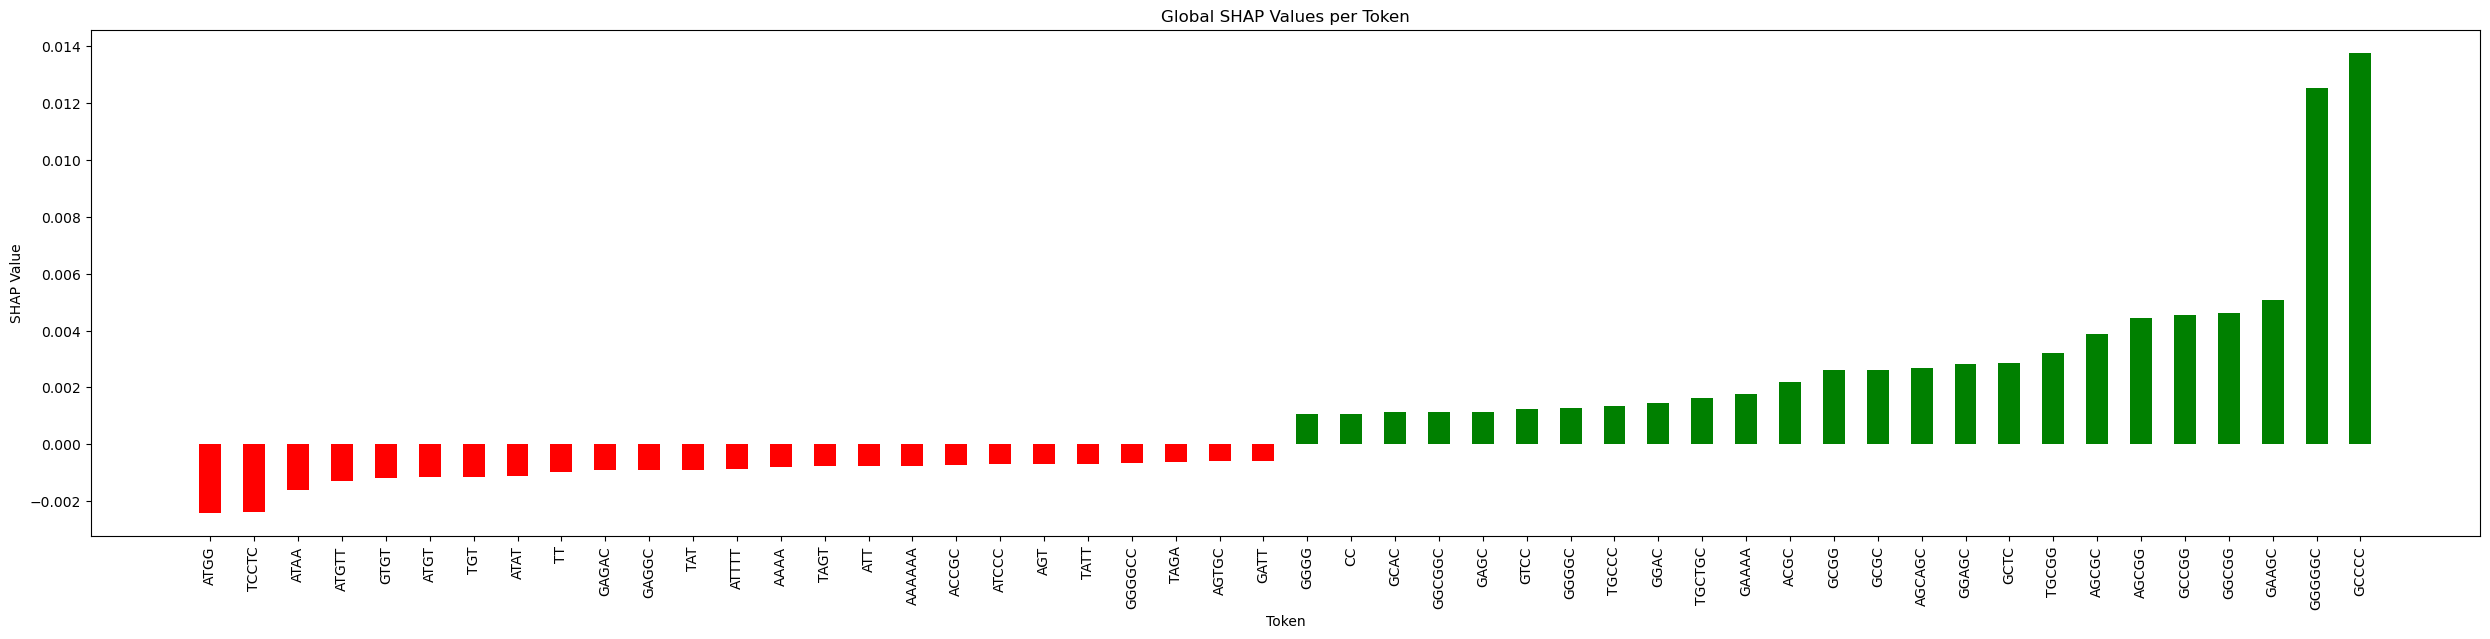

In [ ]:
plot_shap_values(combined_dict, "Global")

In [ ]:
def shap_values_local(record_num):
    # Create a defaultdict with float as the default factory function
    shap_value_per_token = defaultdict(float)

    # Iterate over the tokens in the specified record
    for j, token in enumerate(shap_values.data[record_num]):
        shap_value_for_token_in_seq = shap_values.values[record_num, j, 1]
        shap_value_per_token[token] += shap_value_for_token_in_seq

    # Change keys from tokens to sub-sequence features
    features_shap_value_dict = {}
    for key, item in shap_value_per_token.items():
        detokenized_feature = tokens_and_features_dict.get(key, key)  # Use the key if it doesn't exist in the dict
        features_shap_value_dict[detokenized_feature] = item

    # Remove special tokens if they exist in the dictionary
    special_tokens = ['[PAD]', '[SEP]', '[CLS]']
    for token in special_tokens:
        if token in features_shap_value_dict:
            del features_shap_value_dict[token]

    return features_shap_value_dict

In [ ]:
shap_values_record7 = shap_values_local(57)
shap_values_record1 = shap_values_local(1)
shap_values_record2 = shap_values_local(2)

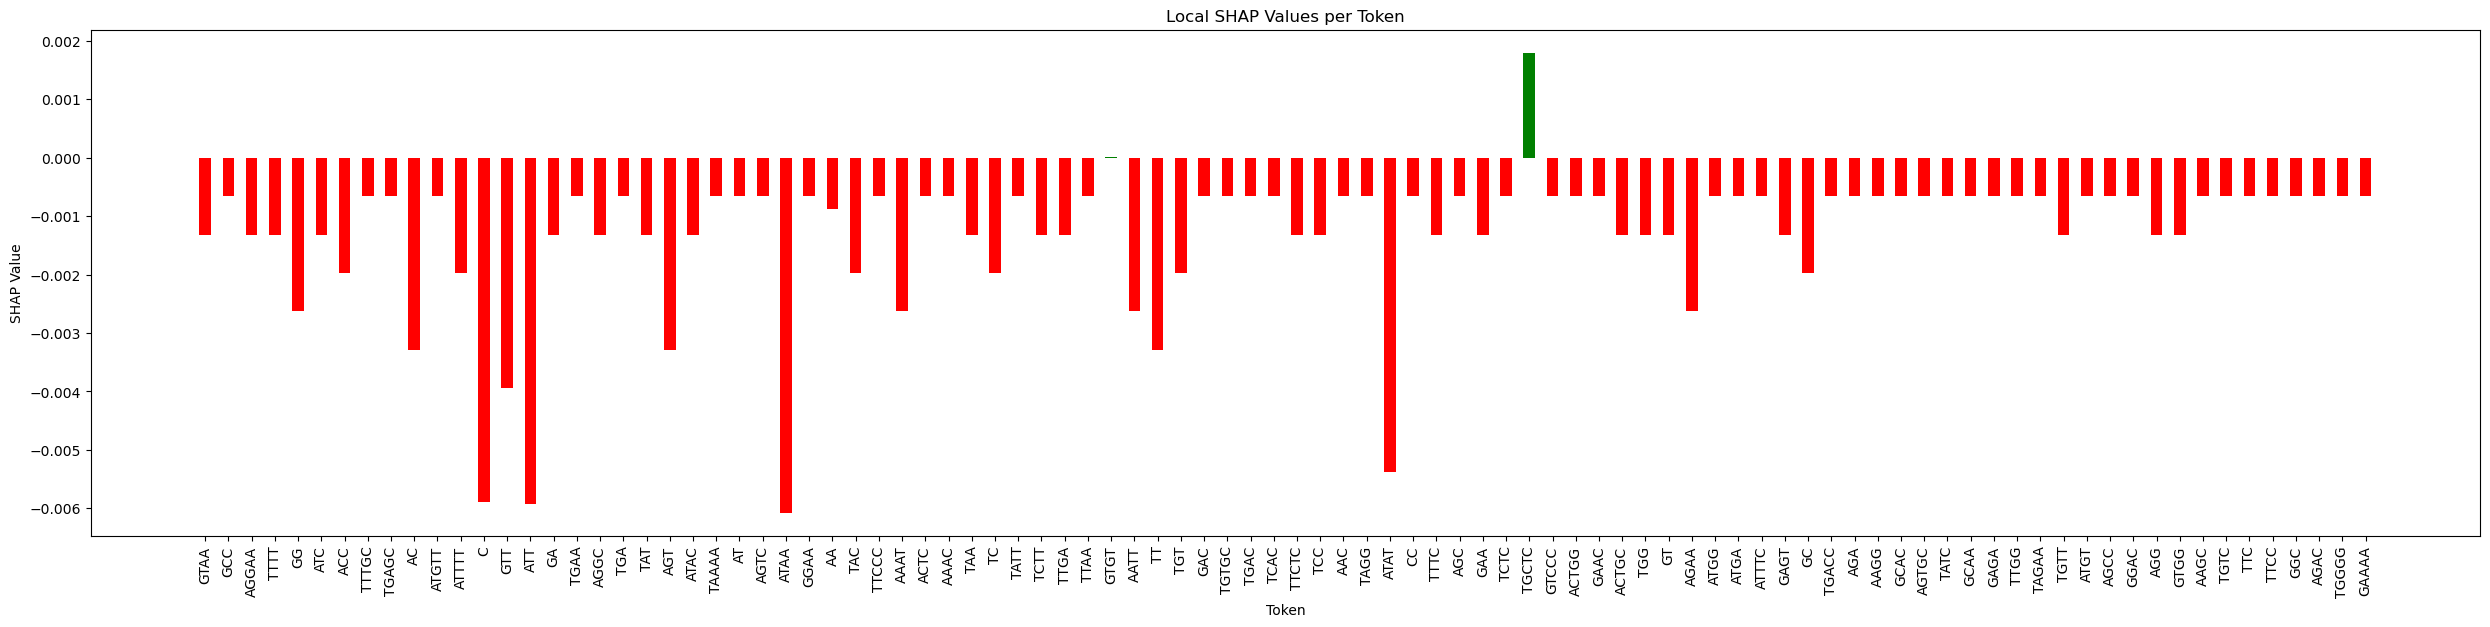

In [ ]:
plot_shap_values(shap_values_record7, "Local")

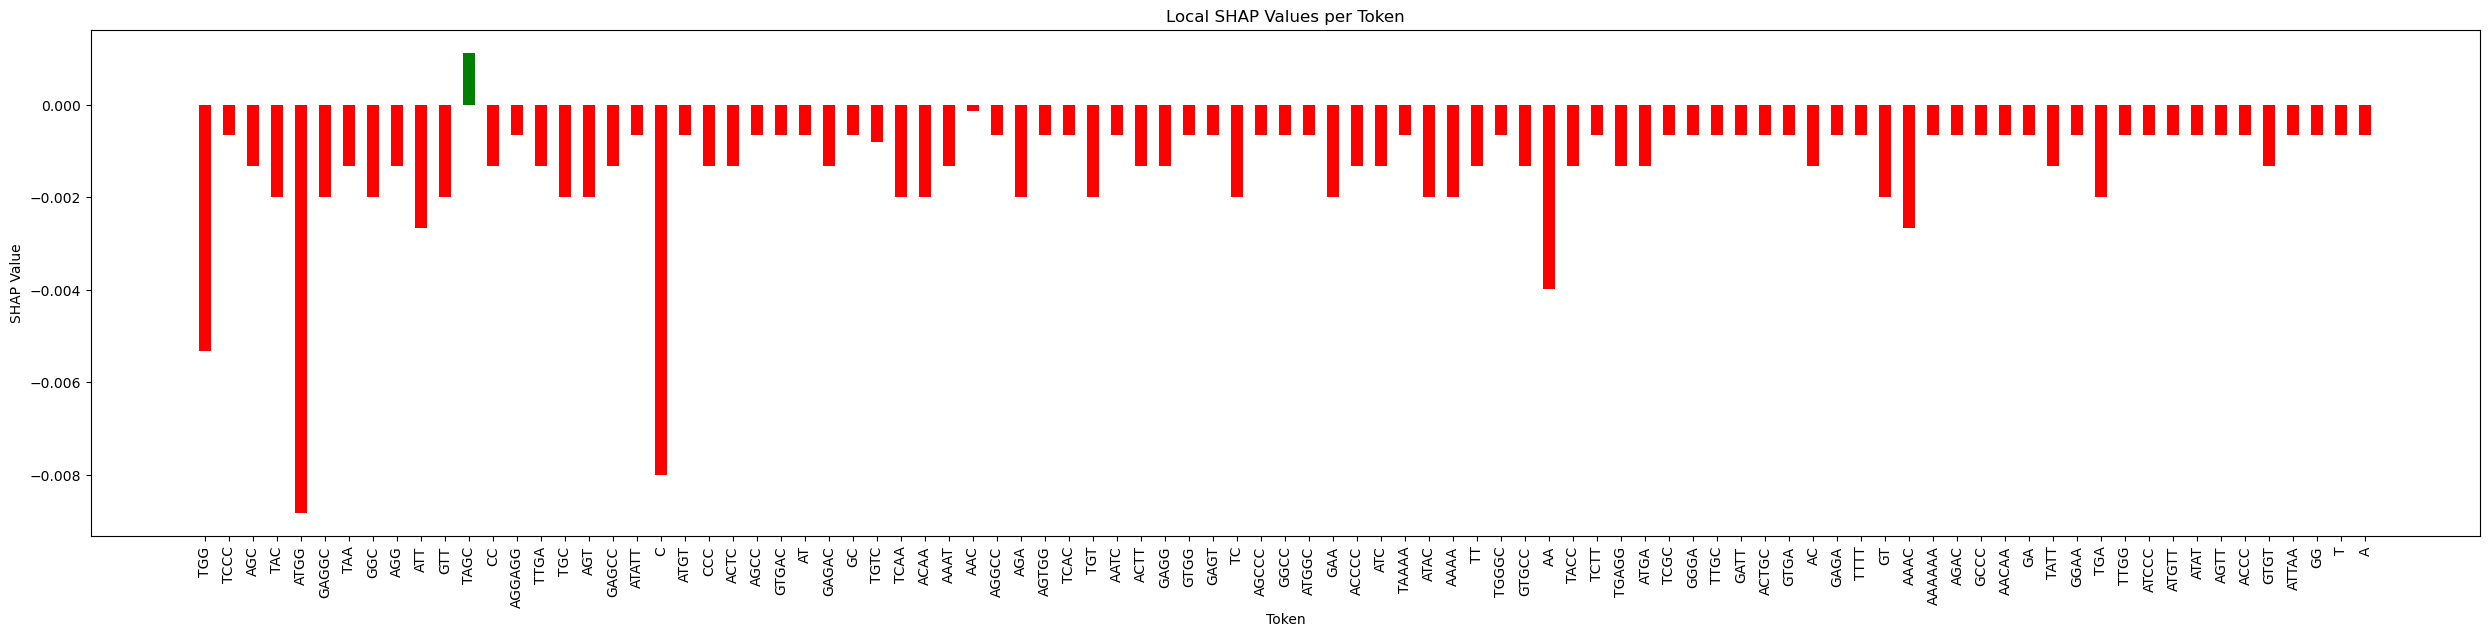

In [ ]:
plot_shap_values(shap_values_record1, "Local")

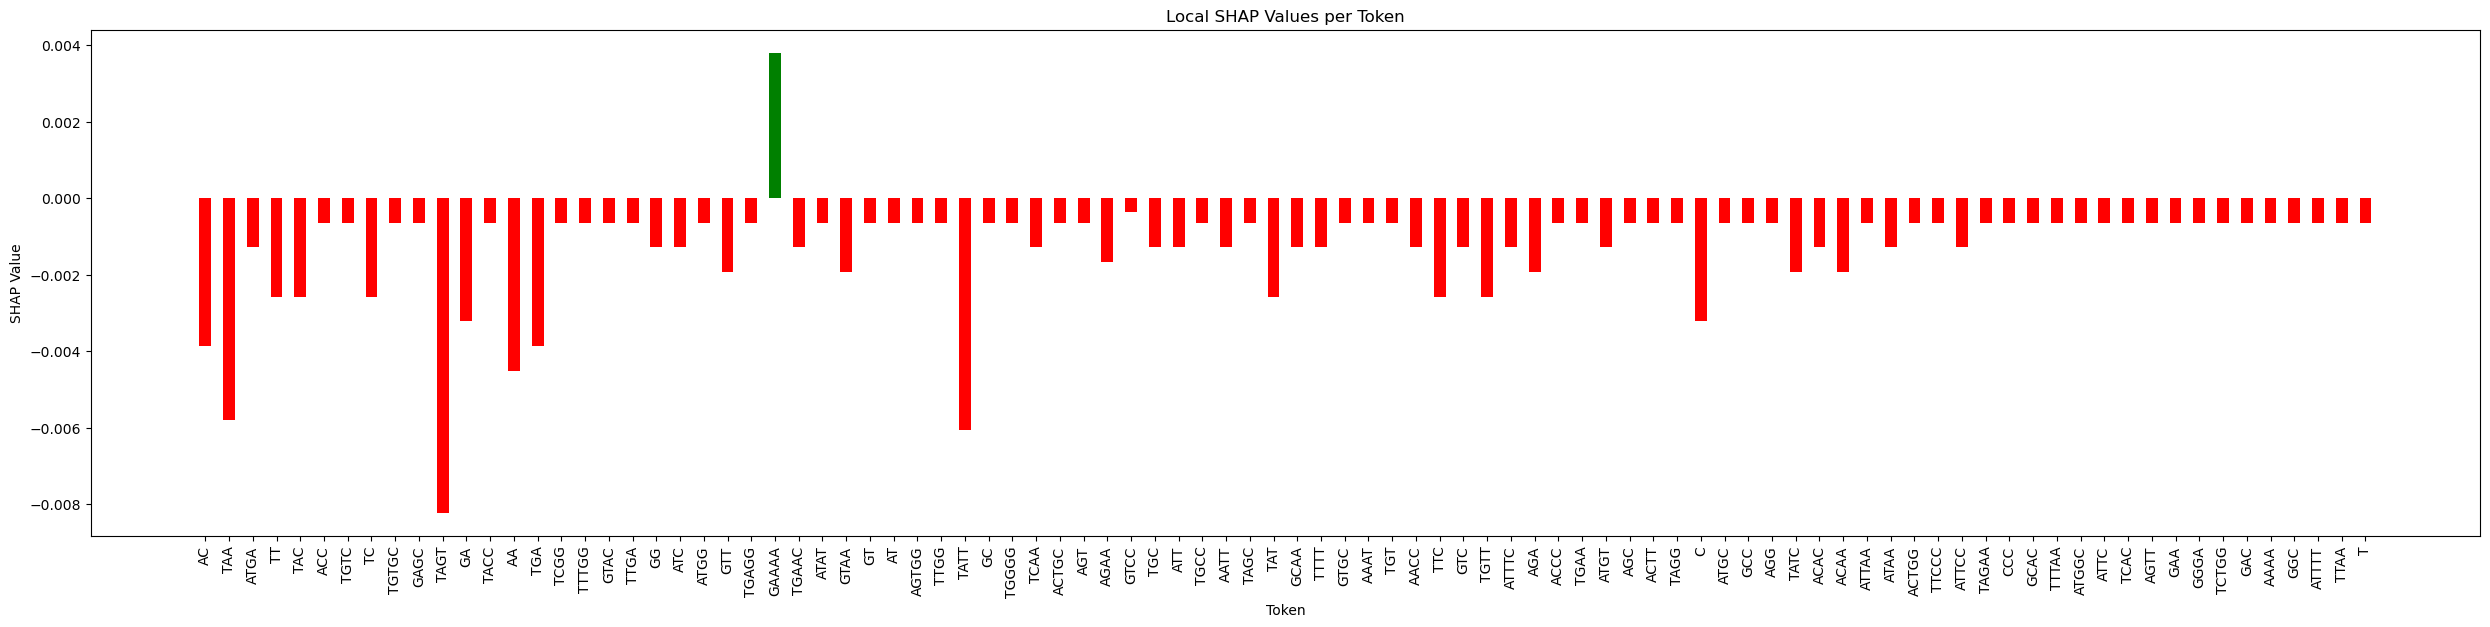

In [ ]:
plot_shap_values(shap_values_record2, "Local")

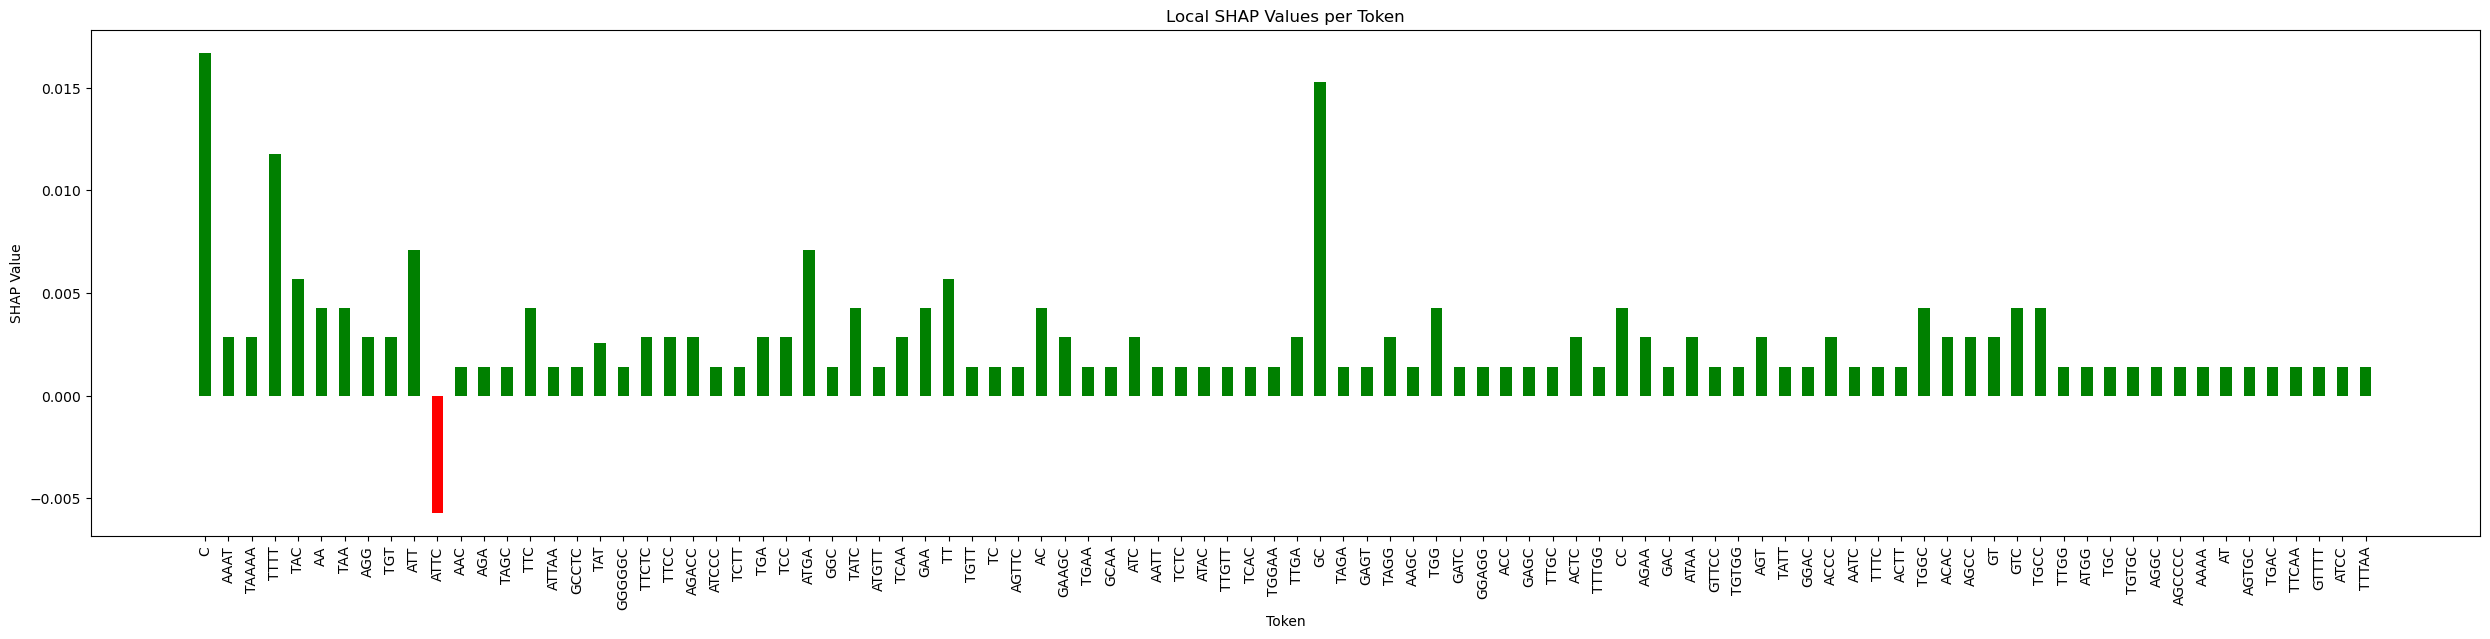

In [ ]:
shap_values_record50 = shap_values_local(50)
plot_shap_values(shap_values_record50, "Local")